In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
from scipy.stats import pearsonr, spearmanr, fisher_exact, mannwhitneyu, ttest_ind

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

from matplotlib.pyplot import rc_context
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
sys.path.append('../../../Code/')
from utils import read_dataset_log
import pickle as pkl


In [2]:
import math

In [3]:
from matplotlib import rcParams, font_manager

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#rcParams['text.usetex'] = True

In [4]:
figdir = '../../../Figures/Components'

In [5]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [6]:
gep_info = read_dataset_log('cGEP_Name')
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))


In [7]:
lineage_geps = gep_info[gep_info['Class']=='Lineage']['Short_Name'].tolist()

In [8]:
aim_assoc_geps = ['Early-Activation',
'ISG',
'BCL2-Survival',
'Treg',
'OX40/EBI3-Activation',
'Cytoskeleton',
'Th17',
'ICOS/CD38-Activation',
'Exhaustion',
'RGCC/MYADM',
'CCR10-Migration',
'CellCycle-S',
'Tfh-2',
'CTLA4+/CD38+-Activation',
'HeatShock',
'Tph',
'Multi-Cytokine',
'TIMD4/TIM3-Activation',
'Th17-2',
'Th2-2',
'Metallothionein',
'CellCycle-Late-S',
'CellCycle-G2M',
                   ]

In [9]:
cc_assoc_geps = ['CTLA4+/CD38+-Activation', 'Cytoskeleton', 'Early-Activation',
       'Exhaustion', 'HLA', 'ICOS/CD38-Activation', 'IL10/IL19-Secretion',
       'Metallothionein', 'OX40/EBI3-Activation', 'TIMD4/TIM3-Activation',
       'Th17-2', 'Tph']

In [10]:
cc_geps = ['CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S']

In [11]:
activation_threshold = 0.0625
cc_threshold = 0.1

In [12]:
phenomap = {
    'COMBAT':{
        'phenocol':'Source',
        'mapping':{'COVID_SEV':'Covid-19', 'Sepsis':np.nan, 'COVID_MILD':'Covid-19', 'COVID_HCW_MILD':'Covid-19', 'HV':'Healthy',
                  'COVID_CRIT':'Covid-19', 'COVID_LDN':'Covid-19', 'Flu':np.nan},
        'allcols':['Source', 'TimeSinceOnset']
    },
    
    'UK-Covid':{
        'phenocol':'Status_on_day_collection_summary',
        'mapping':{'Moderate':'Covid-19', 'Mild':'Covid-19', 'Critical':'Covid-19', 'Severe':'Covid-19', 'Healthy':'Healthy', 'Asymptomatic':np.nan,
                  'Non_covid':np.nan, 'LPS_90mins':np.nan, 'LPS_10hours':np.nan},
        'allcols':['Status_on_day_collection_summary', 'Days_from_onset']
        
    },
    
    'Sparks':{
        'phenocol':'visit',
        'mapping':{'Day 0':'D0', 'Day 1':'D1', 'Day 28':'D28', np.nan:'Control'},
        'allcols':['visit', 'group', 'vaccine']
    },
        
        
    'HIV-Vaccine':{
        'phenocol':'time',
        'mapping':{'0':'D0', '3':'D3', '7':'D7'},
        'allcols':['time'] 
        
    },    

    
    'Pan-Cancer':{
        'phenocol':'loc',
        'mapping':{'T':'Cancer', 'N':'Normal'},
        'allcols':['loc', 'cancerType', 'meta.cluster'] 
        
    },    
    
    # 'AMP-RA':{
    #     'phenocol':'disease_status', 
    #     'mapping':{'RA':'RA', 'OA':'OA'},
    #     'allcols':['disease_status', 'CTAP']
    # }
    
    
}

# Load

In [13]:
convs = ['CD4_Naive', 'CD4_CM', 'CD4_EM', 'CD8_TEMRA', 'CD8_EM', 'CD8_Naive',
       'DP', 'CD8_CM', 'CD4_TEMRA', 'CD4_Memory']
regs = ['Treg']
unconv = ['gdT', 'MAIT', 'DN']
mapping = dict(zip(convs + regs + unconv, ['conv']*len(convs) + ['Treg']*len(regs) + ['unconv']*len(unconv)))

In [14]:
actinfo = {}

for dataset in params.index: #['Pan-Cancer', 'HIV-Vaccine', 'Sparks','COMBAT', 'UK-Covid']:
    
    individual_col = params.loc[dataset, 'individual_col']
    sample_col = params.loc[dataset, 'sample_col']
    count_fn = params.loc[dataset, 'raw_counts_filt_fn']
    meta_fn = params.loc[dataset, 'metadata_fn']
    
    if dataset == 'Pan-Tissue':
        meta = pd.read_csv(meta_fn.replace('metadata', 'metadata_PhenotypeAssociations'), sep='\t', index_col=0)
    else:
        meta = pd.read_csv(meta_fn, sep='\t', index_col=0)
    
    if dataset == 'Sparks':
        meta[sample_col] = meta['alt.subject.id'].astype(str) + meta['visit'].astype(str).replace({'nan':'', 'Day 0':'.D0', 'Day 1':'.D1', 'Day 28':'.D28'})
        
    '''
    adata = sc.read(count_fn)
    if dataset == 'Sparks':
        adata.obs[sample_col] = adata.obs['alt.subject.id'].astype(str) + adata.obs['visit'].astype(str).replace({'nan':'', 'Day 0':'.D0', 'Day 1':'.D1', 'Day 28':'.D28'})
    if dataset == 'Pan-Tissue':
        meta = pd.read_csv(params.loc[dataset, 'metadata_fn'].replace('metadata', 'metadata_PhenotypeAssociations'),
              index_col = 0, sep = '\t')
        adata.obs = meta.loc[adata.obs.index, :]
    '''
    
    usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
    usage.columns = usage.columns.map(rename_map)
    usage_norm = usage.div(usage.sum(axis=1), axis=0)
    
    activation = pd.read_csv(params.loc[dataset, 'activation_score_fn'], index_col = 0, sep = '\t')
    activation_score = activation['Activation_Score']
    activation['Activation_Status'] = activation['Activation_Score'] > activation_threshold
    
    if dataset in phenomap.keys():
        activation = pd.merge(left=activation, right=meta[[individual_col, sample_col] + phenomap[dataset]['allcols']],
                              how='left', left_index=True, right_index=True)
    else:
        activation = pd.merge(left=activation, right=meta[[individual_col, sample_col]],
                              how='left', left_index=True, right_index=True)
    
    if individual_col!=sample_col:
        activation.rename(columns={individual_col:'individual', sample_col:'sample'}, inplace=True)
    else:
        a = activation[sample_col]
        a.columns = ['individual', 'sample']
        activation = activation.drop(sample_col, axis = 1)
        activation.loc[:, ['individual', 'sample']] = a   
        
    activation['CellCycle_Usage'] = usage_norm.loc[activation.index, cc_geps].sum(axis=1)
    activation['Exhaustion_Usage'] = usage_norm.loc[activation.index, 'Exhaustion']
    activation['CellCycle_Bin'] = activation['CellCycle_Usage']>cc_threshold
    activation['Exhaustion_Bin'] = activation['Exhaustion_Usage']>activation_threshold
    
    if dataset not in ['Pan-Cancer', 'AMP-RA', 'TBRU', 'Pan-Tissue', 'Stimseq']:
        gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], sep='\t', index_col=0)['0']
        activation['Gating'] = gating.loc[activation.index]
        activation['Gating_Simple'] = activation['Gating'].replace(mapping)

    if dataset in phenomap.keys():                                                          
        activation['Pheno'] = activation[phenomap[dataset]['phenocol']].replace(phenomap[dataset]['mapping'])
    activation['Dataset'] = dataset
    actinfo[dataset] = activation

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (2,26) have mixed types.Specify dtype option on import or set low_memory=Fals

# Filter duplicates for some datasets

In [15]:
actinfo['Pan-Cancer']['orig.individual'] = actinfo['Pan-Cancer']['individual']
actinfo['Pan-Cancer']['individual'] = actinfo['Pan-Cancer']['individual'].astype(str) + '.' + actinfo['Pan-Cancer']['loc'].astype(str)

In [16]:
actinfo_filt = {}
for dataset in ['Pan-Cancer', 'COMBAT', 'UK-Covid']:
    activation = actinfo[dataset].copy()
    ct = pd.crosstab(activation['individual'], activation['sample'])    
    display((ct>0).sum(axis=1).value_counts())
    ind = (ct>0).sum(axis=1)>1
    ct = ct.loc[ind, :]
    tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)


    tofilt = activation['individual'].isin(tokeep.index) & ~activation['sample'].isin(tokeep.values)
    activation_filt = activation.loc[~tofilt, :]
    ct = pd.crosstab(activation_filt['individual'], activation_filt['sample'])
    display((ct>0).sum(axis=1).value_counts())
    actinfo_filt[dataset] = activation

1    113
2     12
4      7
3      4
dtype: int64

1    136
dtype: int64

1    109
2     10
3      3
dtype: int64

1    122
dtype: int64

1    109
2     12
dtype: int64

1    121
dtype: int64

In [17]:
for dataset in set(params.index) - set(actinfo_filt.keys()):
    actinfo_filt[dataset] = actinfo[dataset]

# Cell cycle enrichment

In [18]:
act_cc_assoc = pd.DataFrame()

for dataset in actinfo_filt.keys():

    activated_cells= actinfo[dataset]['Activation_Status']
    prolif_cells = actinfo[dataset]['CellCycle_Bin']
    activation_score = actinfo[dataset]['Activation_Score']
    cc_score = actinfo[dataset]['CellCycle_Usage']
    
    dat = [(prolif_cells & activated_cells).value_counts(), 
       ((prolif_cells) & -activated_cells).value_counts(),
      (-(prolif_cells) & activated_cells).value_counts(), 
       (-(prolif_cells) & -activated_cells).value_counts()]
    dat = np.array([x[True] if True in x.index else 0 for x in dat]).reshape(2, 2)
    OR, pval_Fisher = fisher_exact(dat)
    log_OR = np.log10(OR)
    log2_OR = np.log2(OR)

    CI_max = math.e**(np.log(OR) + 1.96*math.sqrt(np.sum([1/x for x in dat.reshape(4, 1)])))
    CI_min = math.e**(np.log(OR) - 1.96*math.sqrt(np.sum([1/x for x in dat.reshape(4, 1)])))

    CI_log2_max = log2_OR + 1.96*math.sqrt(np.sum([1/x for x in dat.reshape(4, 1)]))
    CI__log2_min = log2_OR - 1.96*math.sqrt(np.sum([1/x for x in dat.reshape(4, 1)]))
    
    
    r_p, pval_r_p = pearsonr(activation_score, cc_score)
    
    act_cc_assoc = act_cc_assoc.append(pd.DataFrame([dataset, OR,log_OR, log2_OR, CI_max, CI_min, CI_log2_max, CI__log2_min, pval_Fisher,
                                                    r_p, pval_r_p], 
                        index = ['dataset', 'OR', 'log10_OR', 'log2_OR', 'OR_CI_Max', 'OR_CI_Min', 
                                 'log2OR_CI_Max', 'log2OR_CI_Min', 'pval_Fisher', 
                                'R_Pearson', 'pval_R']).T)
    
act_cc_assoc = act_cc_assoc.reset_index(drop = True)
act_cc_assoc.index = act_cc_assoc['dataset']

In [19]:
act_cc_assoc['OR'].astype(float).apply(np.log2)

dataset
Pan-Cancer     2.209368
COMBAT         5.878724
UK-Covid       2.177709
Pan-Tissue     3.159312
TBRU           4.498115
Sparks         2.709294
AMP-RA         1.497689
Stimseq        2.420358
HIV-Vaccine    2.635199
Name: OR, dtype: float64

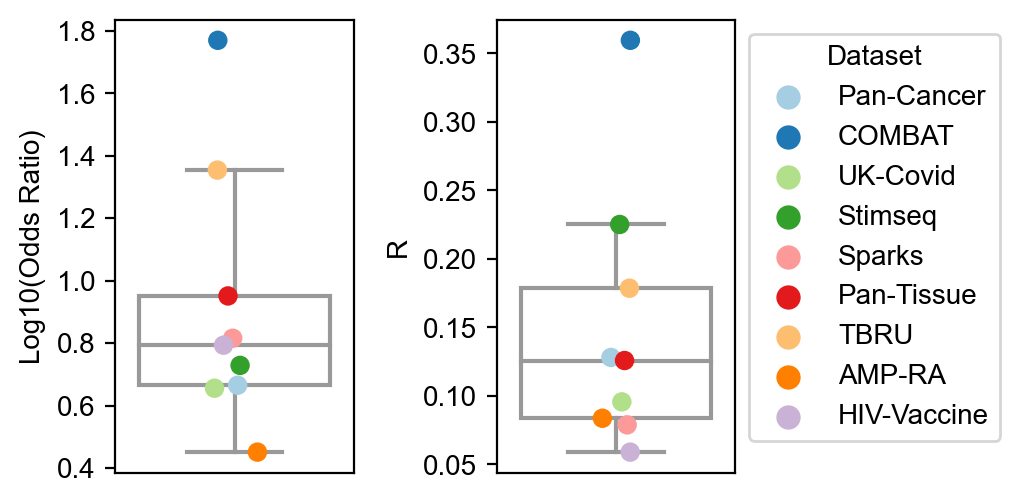

In [20]:
fig, axes = plt.subplots(dpi = 200, figsize =(4, 3), ncols = 2, gridspec_kw = {'wspace' :0.6})


y = act_cc_assoc['log10_OR']
ax = axes[0]
sns.stripplot(x = [0]*len(y), y= y, zorder = 3, size = 7, 
              hue = act_cc_assoc['dataset'], palette= 'Paired', ax = ax)
sns.boxplot(y= y, ax = ax, color = 'white', showfliers=False)
ax.set_ylabel('Log10(Odds Ratio)')
ax.set_xticks([])
ax.get_legend().remove()



y = act_cc_assoc['R_Pearson']
ax = axes[1]
sns.stripplot(x = [0]*len(y), y= y, zorder = 3, size = 7, 
              hue = act_cc_assoc['dataset'], palette= 'Paired', ax = ax)
sns.boxplot(y= y, ax = ax, color = 'white', showfliers=False)
ax.set_ylabel('R')
ax.set_xticks([])


ax.legend(bbox_to_anchor=(1, 1), title = 'Dataset')

# fig.savefig(os.path.join(figdir, 'Stripplot_Activation_CellCyle_Corr+OddsRatio.png'), bbox_inches="tight")
# fig.savefig(os.path.join(figdir, 'Stripplot_Activation_CellCyle_Corr+OddsRatio.pdf'), bbox_inches="tight")

In [21]:
act_cc_assoc['OR'].sort_values(ascending = False).index

Index(['COMBAT', 'TBRU', 'Pan-Tissue', 'Sparks', 'HIV-Vaccine', 'Stimseq',
       'Pan-Cancer', 'UK-Covid', 'AMP-RA'],
      dtype='object', name='dataset')

In [22]:
props = {'boxprops':{'edgecolor':'black'},
'medianprops':{'color':'black'},
'whiskerprops':{'color':'black'},
'capprops':{'color':'black'}}

In [23]:
act_cc_assoc

,dataset,OR,log10_OR,log2_OR,OR_CI_Max,OR_CI_Min,log2OR_CI_Max,log2OR_CI_Min,pval_Fisher,R_Pearson,pval_R
dataset,,,,,,,,,,,
Pan-Cancer,Pan-Cancer,4.624727,0.665086,2.209368,4.847016,4.412632,2.256314,2.162422,0.0,0.128035,0.0
COMBAT,COMBAT,58.839952,1.769672,5.878724,62.451945,55.436863,5.9383,5.819148,0.0,0.359517,0.0
UK-Covid,UK-Covid,4.524344,0.655556,2.177709,4.913189,4.166274,2.260159,2.095258,0.0,0.095613,0.0
Stimseq,Stimseq,5.353038,0.7286,2.420358,6.244866,4.588571,2.574453,2.266262,0.0,0.225089,0.0
Sparks,Sparks,6.540017,0.815579,2.709294,7.548648,5.666157,2.852723,2.565866,0.0,0.078829,0.0
Pan-Tissue,Pan-Tissue,8.934038,0.951048,3.159312,10.249058,7.787744,3.29663,3.021995,0.0,0.125795,0.0
TBRU,TBRU,22.597869,1.354067,4.498115,24.750047,20.632836,4.589087,4.407143,0.0,0.178567,0.0
AMP-RA,AMP-RA,2.8239,0.450849,1.497689,3.126104,2.55091,1.599358,1.39602,0.0,0.083653,0.0
HIV-Vaccine,HIV-Vaccine,6.212609,0.793274,2.635199,7.967822,4.844048,2.884029,2.386369,0.0,0.05893,0.0


In [24]:
act_cc_assoc

,dataset,OR,log10_OR,log2_OR,OR_CI_Max,OR_CI_Min,log2OR_CI_Max,log2OR_CI_Min,pval_Fisher,R_Pearson,pval_R
dataset,,,,,,,,,,,
Pan-Cancer,Pan-Cancer,4.624727,0.665086,2.209368,4.847016,4.412632,2.256314,2.162422,0.0,0.128035,0.0
COMBAT,COMBAT,58.839952,1.769672,5.878724,62.451945,55.436863,5.9383,5.819148,0.0,0.359517,0.0
UK-Covid,UK-Covid,4.524344,0.655556,2.177709,4.913189,4.166274,2.260159,2.095258,0.0,0.095613,0.0
Stimseq,Stimseq,5.353038,0.7286,2.420358,6.244866,4.588571,2.574453,2.266262,0.0,0.225089,0.0
Sparks,Sparks,6.540017,0.815579,2.709294,7.548648,5.666157,2.852723,2.565866,0.0,0.078829,0.0
Pan-Tissue,Pan-Tissue,8.934038,0.951048,3.159312,10.249058,7.787744,3.29663,3.021995,0.0,0.125795,0.0
TBRU,TBRU,22.597869,1.354067,4.498115,24.750047,20.632836,4.589087,4.407143,0.0,0.178567,0.0
AMP-RA,AMP-RA,2.8239,0.450849,1.497689,3.126104,2.55091,1.599358,1.39602,0.0,0.083653,0.0
HIV-Vaccine,HIV-Vaccine,6.212609,0.793274,2.635199,7.967822,4.844048,2.884029,2.386369,0.0,0.05893,0.0


In [20]:
ds_pal = {'COMBAT' : '#D0A6FF', 'Sparks' : 'lightskyblue', 'TBRU' : 'magenta', 'Pan-Tissue' : 'gold',
         'AMP-RA' : 'mediumturquoise', 'UK-Covid' : 'lightpink', 'Stimseq' : 'palegreen', 'HIV-Vaccine' : 'coral',
         'Pan-Cancer' : 'mediumblue'}

for dataset in set(act_cc_assoc['dataset']).difference(ds_pal.keys()):
    print(dataset)
    ds_pal[dataset] = 'grey'

In [26]:
ds_pal

{'COMBAT': '#D0A6FF',
 'Sparks': 'lightskyblue',
 'TBRU': 'magenta',
 'Pan-Tissue': 'gold',
 'AMP-RA': 'mediumturquoise',
 'UK-Covid': 'lightpink',
 'Stimseq': 'palegreen',
 'HIV-Vaccine': 'coral',
 'Pan-Cancer': 'mediumblue'}

In [21]:
label_fontsize = 10
tick_fontsize = 8

In [28]:
act_cc_assoc['OR'].sort_values().index

Index(['AMP-RA', 'UK-Covid', 'Pan-Cancer', 'Stimseq', 'HIV-Vaccine', 'Sparks',
       'Pan-Tissue', 'TBRU', 'COMBAT'],
      dtype='object', name='dataset')

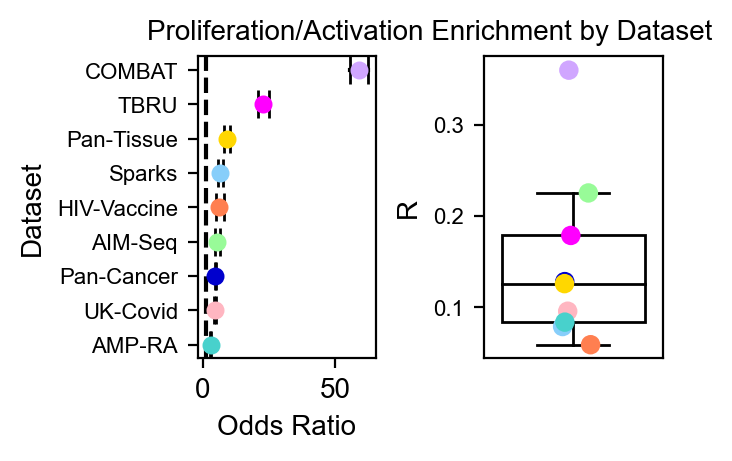

In [29]:
fig, axes = plt.subplots(dpi = 200, figsize =(3, 2), ncols = 2, gridspec_kw = {'wspace' :0.6})

ax = axes[0]
for n, dataset in enumerate(act_cc_assoc['OR'].sort_values().index):
    x = [act_cc_assoc.loc[dataset, 'OR_CI_Min'], act_cc_assoc.loc[dataset, 'OR_CI_Max']]
    y = [n, n]
    ax.plot(x, y, "-", markersize = .01, color = 'black', zorder = 3)
    ax.plot(x, y,  "|", markersize = 10, color = 'black', zorder = 3)
    ax.scatter(act_cc_assoc.loc[dataset, 'OR'], n, zorder =4, s = 30, c = ds_pal[dataset])
ylim  = ax.get_ylim()
ax.vlines(x = 1, ymin = ylim[0], ymax = ylim[1], linestyles = 'dashed', color = 'black')
ax.set_ylim(ylim)
ax.set_yticks(np.arange(0, n+1))
ax.set_yticklabels(pd.Series(act_cc_assoc['OR'].sort_values().index).replace({'Stimseq' : 'AIM-Seq'}), 
                   fontsize = tick_fontsize)
ax.set_ylabel('Dataset', fontsize = label_fontsize)

# # sns.boxplot(y= y, ax = ax, color = 'white', showfliers=False)
ax.set_xlabel('Odds Ratio', fontsize = label_fontsize)
# ax.set_xticks([])
# ax.get_legend().remove()



y = act_cc_assoc['R_Pearson']
ax = axes[1]
sns.stripplot(x = [0]*len(y), y= y, zorder = 3, size = 7, hue_order = act_cc_assoc['OR'].sort_values().index,
              hue = act_cc_assoc['dataset'], palette= ds_pal,
              ax = ax)
sns.boxplot(y= y, ax = ax, color = 'white', showfliers=False, linewidth = 1,
           **props)
ax.set_ylabel('R', fontsize = label_fontsize)
ax.set_xticks([])
ax.tick_params(labelsize = tick_fontsize)

ax.get_legend().remove()

ax.set_title('Proliferation/Activation Enrichment by Dataset', fontsize = label_fontsize, x = -.3)

# ax.legend(bbox_to_anchor=(1, 1), title = 'Dataset')

fig.savefig(os.path.join(figdir, 'Activation_CellCyle_Corr+OddsRatio.png'), bbox_inches="tight")
fig.savefig(os.path.join(figdir, 'Activation_CellCyle_Corr+OddsRatio.pdf'), bbox_inches="tight")

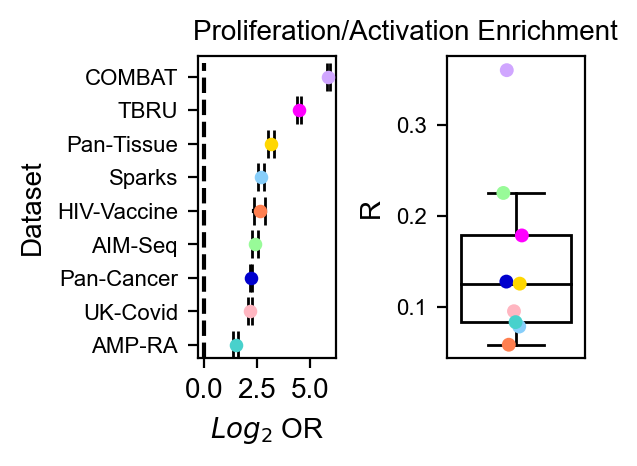

In [30]:
fig, axes = plt.subplots(dpi = 200, figsize =(2.5, 2), ncols = 2, gridspec_kw = {'wspace' :0.8})

ax = axes[0]
for n, dataset in enumerate(act_cc_assoc['log2_OR'].sort_values().index):
    x = [act_cc_assoc.loc[dataset, 'log2OR_CI_Min'], act_cc_assoc.loc[dataset, 'log2OR_CI_Max']]
    y = [n, n]
    ax.plot(x, y, "-", markersize = .01, color = 'black', zorder = 3)
    ax.plot(x, y,  "|", markersize = 10, color = 'black', zorder = 3)
    ax.scatter(act_cc_assoc.loc[dataset, 'log2_OR'], n, zorder =4, s = 15, c = ds_pal[dataset])
ylim  = ax.get_ylim()
ax.vlines(x = 0, ymin = ylim[0], ymax = ylim[1], linestyles = 'dashed', color = 'black')
ax.set_ylim([ylim[0], ylim[1]+.2])
ax.set_xticks([0, 2.5, 5])
ax.set_yticks(np.arange(0, n+1))
ax.set_yticklabels(pd.Series(act_cc_assoc['OR'].sort_values().index).replace({'Stimseq' : 'AIM-Seq'}), 
                   fontsize = tick_fontsize)
ax.set_ylabel('Dataset', fontsize = label_fontsize)

# # sns.boxplot(y= y, ax = ax, color = 'white', showfliers=False)
ax.set_xlabel('$Log_{2}$ OR', fontsize = label_fontsize)
# ax.set_xticks([])
# ax.get_legend().remove()



y = act_cc_assoc['R_Pearson']
ax = axes[1]
sns.stripplot(x = [0]*len(y), y= y, zorder = 3, size = 5, hue_order = act_cc_assoc['OR'].sort_values().index,
              hue = act_cc_assoc['dataset'], palette= ds_pal,
              ax = ax)
sns.boxplot(y= y, ax = ax, color = 'white', showfliers=False, linewidth = 1,
           **props)
ax.set_ylabel('R', fontsize = label_fontsize)
ax.set_xticks([])
ax.tick_params(labelsize = tick_fontsize)

ax.get_legend().remove()

ax.set_title('Proliferation/Activation Enrichment', fontsize = label_fontsize, x = -.3)

# ax.legend(bbox_to_anchor=(1, 1), title = 'Dataset')

fig.savefig(os.path.join(figdir, 'Activation_CellCyle_Corr+Log2OddsRatio.png'), bbox_inches="tight")
fig.savefig(os.path.join(figdir, 'Activation_CellCyle_Corr+Log2OddsRatio.pdf'), bbox_inches="tight")

In [22]:
for dataset in actinfo_filt.keys():

    activated_cells= actinfo[dataset]['Activation_Status']
    prolif_cells = actinfo[dataset]['CellCycle_Bin']
    activation_score = actinfo[dataset]['Activation_Score']
    cc_score = actinfo[dataset]['CellCycle_Usage']
    nact = activated_cells.sum()
    actandprolif = (activated_cells & prolif_cells).sum()
    print(dataset, actandprolif / nact, nact, actandprolif)

Pan-Cancer 0.08609481864187858 47227 4066
COMBAT 0.18009937238493723 38240 6887
UK-Covid 0.02183067571139107 56755 1239
Pan-Tissue 0.024543566196567182 18294 449
TBRU 0.03073436083408885 66180 2034
Sparks 0.0084778952703481 43407 368
AMP-RA 0.033136564313706034 20159 668
Stimseq 0.04269756759578244 9579 409
HIV-Vaccine 0.014114232950798047 7581 107


By sample: percent activated vs percent proliferating

In [23]:
merged = pd.DataFrame()

for dataset in params.index:
    X = actinfo_filt[dataset][['Activation_Status', 'individual', 'CellCycle_Bin', 'Dataset']]
    merged = pd.concat([merged, X], axis=0)
    print(dataset)


sample_average = (merged.groupby(['Dataset', 'individual']).mean()*100).reset_index()

AMP-RA
Pan-Cancer
TBRU
HIV-Vaccine
UK-Covid
COMBAT
Pan-Tissue
Sparks
Stimseq


Text(0, 0.5, 'Cell Cycle Score')

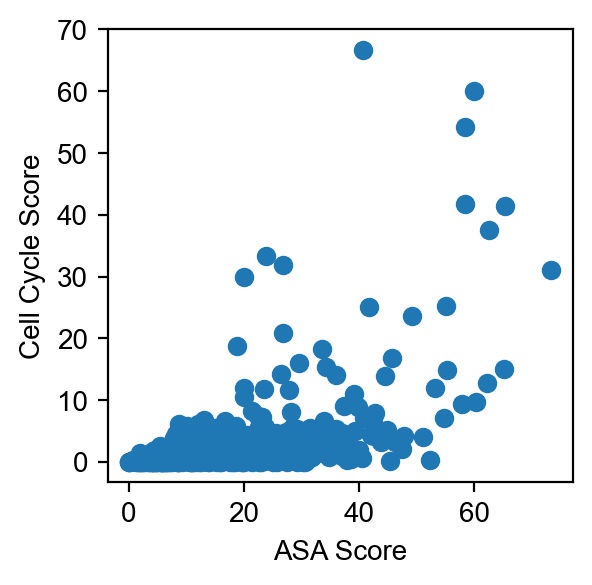

In [33]:
x = sample_average['Activation_Status']
y = sample_average['CellCycle_Bin']

r = pearsonr(x, y)
fig, ax = plt.subplots(dpi = 200, figsize = (3, 3))
ax.scatter(x, y)
ax.set_xlabel('ASA Score')
ax.set_ylabel('Cell Cycle Score')

In [24]:
summary = sample_average.groupby(['Dataset']).median().reset_index().melt(
            id_vars = ['Dataset'], value_name = 'Median')
dataset_average = summary

summary = sample_average.groupby(['Dataset'])[[
    'Activation_Status', 'CellCycle_Bin']].quantile(0.75).reset_index().melt(
            id_vars = ['Dataset'], value_name = 'Qtl_0_75')

dataset_average = pd.merge(dataset_average, summary)
summary = sample_average.groupby(['Dataset'])[[
    'Activation_Status', 'CellCycle_Bin']].quantile(0.25).reset_index().melt(
            id_vars = ['Dataset'], value_name = 'Qtl_0_25')

dataset_average = pd.merge(dataset_average, summary)

In [25]:
dataset_average['MinErr'] = dataset_average['Median'] -dataset_average['Qtl_0_25'] 
dataset_average['MaxErr'] = dataset_average['Qtl_0_75'] -dataset_average['Median'] 

order = dataset_average[dataset_average['variable']=='Activation_Status'].sort_values('Median', ascending = False)['Dataset']


dataset_average['variable_label'] = dataset_average['variable'].replace({'Activation_Status' : 'Activated',
                                                                   'CellCycle_Bin' : 'Proliferating'})

In [36]:
order

0         AMP-RA
3     Pan-Cancer
8       UK-Covid
6        Stimseq
4     Pan-Tissue
5         Sparks
7           TBRU
2    HIV-Vaccine
1         COMBAT
Name: Dataset, dtype: object

In [37]:
dataset_average

,Dataset,variable,Median,Qtl_0_75,Qtl_0_25,MinErr,MaxErr,variable_label
0,AMP-RA,Activation_Status,19.850746,29.525300,11.009174,8.841572,9.674554,Activated
1,COMBAT,Activation_Status,8.950149,12.912465,5.616847,3.333303,3.962316,Activated
2,HIV-Vaccine,Activation_Status,9.381143,11.113555,8.058665,1.322479,1.732411,Activated
3,Pan-Cancer,Activation_Status,19.665108,34.234483,7.377491,12.287618,14.569374,Activated
4,Pan-Tissue,Activation_Status,14.474534,17.972594,9.028932,5.445602,3.498060,Activated
5,Sparks,Activation_Status,12.557001,14.906964,10.163126,2.393875,2.349963,Activated
6,Stimseq,Activation_Status,18.239745,28.339576,15.494045,2.745700,10.099830,Activated
7,TBRU,Activation_Status,11.061202,16.087639,7.188488,3.872713,5.026437,Activated
8,UK-Covid,Activation_Status,18.454106,27.349229,11.422846,7.031261,8.895122,Activated
9,AMP-RA,CellCycle_Bin,1.161890,2.506266,0.470588,0.691302,1.344376,Proliferating


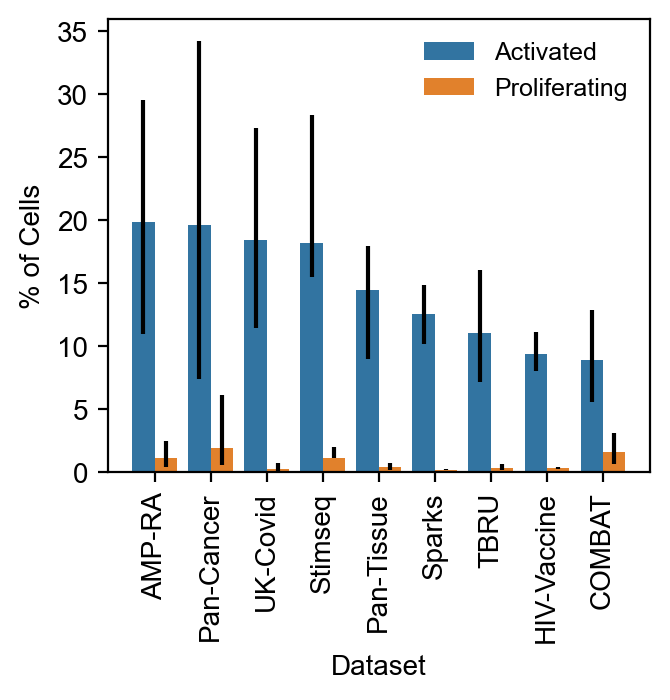

In [38]:
fig, ax = plt.subplots(dpi = 200, figsize =(3.5, 3))
sns.barplot(x= dataset_average['Dataset'], y = dataset_average['Median'],
            hue = dataset_average['variable_label'],
            ax = ax, order = order)

for n, variable in enumerate(['Activated', 'Proliferating']):
    ds_average_v = dataset_average[dataset_average['variable_label']==variable]
    ds_average_v.index = ds_average_v['Dataset']
    ds_average_v = ds_average_v.loc[order, :]
    ds_average_v['rank'] = range(0, ds_average_v.shape[0])
    
    if n ==0:
        x = ds_average_v['rank'] - .2
        
    elif n ==1:
        x = ds_average_v['rank'] + .2

    ax.errorbar(x= x, y =ds_average_v['Median'], 
                yerr=(ds_average_v['MinErr'], 
                     ds_average_v['MaxErr']), fmt="none", c="k")
ax.tick_params('x', rotation = 90)
ax.set_ylabel('% of Cells')
ax.legend(bbox_to_anchor=(1, 1), title = None, fontsize = 9, frameon=False)
plt.savefig(os.path.join(figdir, 'PctCellsActivatedProlif.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'PctCellsActivatedProlif.pdf'), bbox_inches="tight")


In [39]:
sample_average

,Dataset,individual,Activation_Status,CellCycle_Bin
0,AMP-RA,BRI-399,20.190779,0.476948
1,AMP-RA,BRI-401,15.360000,0.800000
2,AMP-RA,BRI-403,22.622108,3.598972
3,AMP-RA,BRI-405,25.581395,4.651163
4,AMP-RA,BRI-407,28.096249,1.486200
...,...,...,...,...
780,UK-Covid,newcastle21v2,36.996736,0.870511
781,UK-Covid,newcastle49,28.404982,0.642828
782,UK-Covid,newcastle59,21.097446,0.283822
783,UK-Covid,newcastle65,22.084806,0.075719


In [26]:
sample_average_long = sample_average.melt(id_vars = ['Dataset', 'individual'])

sample_average_long['variable_label'] = sample_average_long['variable'].replace({'Activation_Status' : 'Activated',
                                                                   'CellCycle_Bin' : 'Proliferating'})

In [27]:
from scipy.stats import ttest_rel

In [42]:
sample_average

,Dataset,individual,Activation_Status,CellCycle_Bin
0,AMP-RA,BRI-399,20.190779,0.476948
1,AMP-RA,BRI-401,15.360000,0.800000
2,AMP-RA,BRI-403,22.622108,3.598972
3,AMP-RA,BRI-405,25.581395,4.651163
4,AMP-RA,BRI-407,28.096249,1.486200
...,...,...,...,...
780,UK-Covid,newcastle21v2,36.996736,0.870511
781,UK-Covid,newcastle49,28.404982,0.642828
782,UK-Covid,newcastle59,21.097446,0.283822
783,UK-Covid,newcastle65,22.084806,0.075719


In [28]:
t, pval = ttest_rel(sample_average['Activation_Status'], sample_average['CellCycle_Bin'])

In [29]:
t, pval

(39.51374276367523, 9.868240305047122e-189)

In [30]:
sample_average_long['Dataset_Label'] = sample_average_long['Dataset'].replace({'Stimseq' : 'AIM-Seq'})

In [31]:
sample_average_long['Dataset'].unique()

array(['AMP-RA', 'COMBAT', 'HIV-Vaccine', 'Pan-Cancer', 'Pan-Tissue',
       'Sparks', 'Stimseq', 'TBRU', 'UK-Covid'], dtype=object)

In [32]:
sample_average_long['variable_label'].value_counts()

Activated        785
Proliferating    785
Name: variable_label, dtype: int64

In [33]:
pal = {'ASA+' : 'dodgerblue',
      'Cell Cycle +' : 'gold'}

In [34]:
sample_average_long['variable_label_rename'] = sample_average_long['variable_label'].replace({'Activated':'ASA+', 'Proliferating':'Cell Cycle +'})

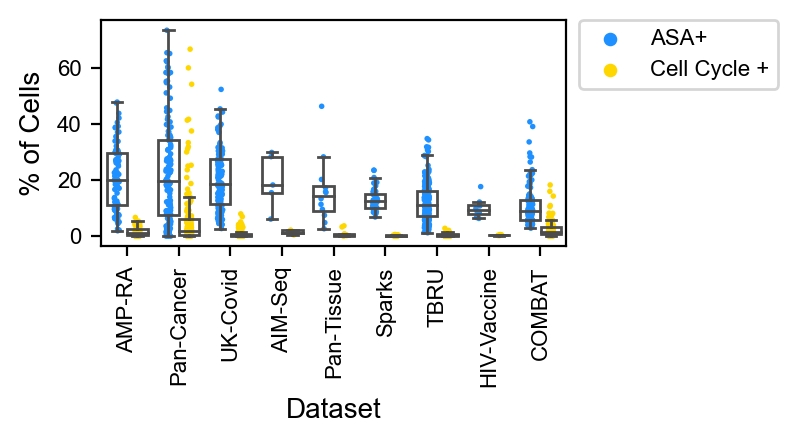

In [37]:
fig, ax = plt.subplots(dpi = 200, figsize =(3, 1.5))
sns.boxplot(x= 'Dataset_Label', y = 'value',
            hue = 'variable_label_rename', #linewidth =1.1,
            ax = ax, order = order.replace({'Stimseq' : 'AIM-Seq'}), 
            data = sample_average_long,
           showfliers=False ,
            palette = pal, zorder = 3, boxprops=dict(facecolor='none', zorder = 3), 
            linewidth = 1)

sns.stripplot(x= 'Dataset_Label', y = 'value',
            hue = 'variable_label_rename',
              order = order.replace({'Stimseq' : 'AIM-Seq'}),
              ax = ax, data = sample_average_long, dodge = True, palette = pal, zorder = 1, s = 2)


ax.tick_params('x', rotation = 90)
ax.tick_params('both', labelsize = tick_fontsize)
ax.set_ylabel('% of Cells', fontsize = label_fontsize)
ax.set_xlabel('Dataset', fontsize = label_fontsize)

# ax.text(x = .68, y = .83, s= '$P<1x10^{-100}$' % pval, fontsize = 8, transform=ax.transAxes)

# Remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.48, 1.05), title = None, 
          fontsize = tick_fontsize, markerscale=.5)

plt.savefig(os.path.join(figdir, 'PctCellsActivatedProlif_Boxplot.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'PctCellsActivatedProlif_Boxplot.pdf'), bbox_inches="tight")


# Lineage enrichment

In [66]:
np.log2

<ufunc 'log2'>

In [67]:
lineage_assoc = pd.DataFrame()

for dataset in ['COMBAT', 'Sparks']:


    activated_cells= actinfo[dataset]['Activation_Status']
    pheno = actinfo[dataset]['Pheno']
    gating = actinfo[dataset]['Gating']

    for p in pheno.dropna().unique():
        print(p)
        ind_pheno = pheno==p

        for lineage in list(gating.dropna().unique()):
            print(lineage)
            dat = [((gating[ind_pheno]==lineage) & activated_cells[ind_pheno]).value_counts(), 
                   ((gating[ind_pheno]==lineage) & -activated_cells[ind_pheno]).value_counts(),
                  (-(gating[ind_pheno]==lineage) & activated_cells[ind_pheno]).value_counts(), 
                   (-(gating[ind_pheno]==lineage) & -activated_cells[ind_pheno]).value_counts()]
            dat = np.array([x[True] if True in x.index else 0 for x in dat]).reshape(2, 2)

            OR, pval_Fisher = fisher_exact(dat)
            log_OR = np.log2(OR)

            lineage_assoc = lineage_assoc.append(pd.DataFrame([dataset, p, lineage, OR, log_OR, pval_Fisher,
                                                            ], 
                                index = ['dataset', 'Pheno', 'Lineage', 'OR', 'log2_OR', 'pval_Fisher', 
                                        ]).T)



Covid-19
CD8_EM
CD4_CM
CD4_EM
CD8_TEMRA
CD4_Naive
MAIT
CD8_Naive
CD8_CM
DP
Treg
CD4_TEMRA
DN
gdT
Healthy
CD8_EM
CD4_CM
CD4_EM
CD8_TEMRA
CD4_Naive
MAIT
CD8_Naive
CD8_CM
DP
Treg
CD4_TEMRA
DN
gdT
Control
CD4_Naive
CD4_CM
CD8_EM
CD4_EM
Treg
CD8_TEMRA
CD8_Naive
CD4_TEMRA
MAIT
gdT
DN
DP
CD8_CM
D0
CD4_Naive
CD4_CM
CD8_EM
CD4_EM
Treg
CD8_TEMRA
CD8_Naive
CD4_TEMRA
MAIT
gdT
DN
DP
CD8_CM
D1
CD4_Naive
CD4_CM
CD8_EM
CD4_EM
Treg
CD8_TEMRA
CD8_Naive
CD4_TEMRA
MAIT
gdT
DN
DP
CD8_CM
D28
CD4_Naive
CD4_CM
CD8_EM
CD4_EM
Treg
CD8_TEMRA
CD8_Naive
CD4_TEMRA
MAIT
gdT
DN
DP
CD8_CM


In [68]:
lineage_assoc['padj_Fisher'] = lineage_assoc['pval_Fisher']*lineage_assoc.shape[0]

In [69]:
lineage_OR = lineage_assoc.pivot(index = ['dataset', 'Pheno'], 
                                 columns = 'Lineage', values = 'OR')

In [70]:
lineage_logOR = lineage_assoc.pivot(index = ['dataset', 'Pheno'], 
                                 columns = 'Lineage', values = 'log2_OR')

In [71]:
lineage_logOR

Lineage             CD4_CM    CD4_EM CD4_Naive CD4_TEMRA    CD8_CM    CD8_EM  \
dataset Pheno                                                                  
COMBAT  Covid-19  0.467364  0.713751 -3.094172 -0.479425  2.249272  1.501231   
        Healthy   1.205488  1.425552 -2.393764 -1.327707    0.3936 -0.519295   
Sparks  Control   0.965106  1.344025 -2.438956 -1.323357 -0.827691 -0.425854   
        D0        1.357965  1.651717  -2.30722 -1.614689  0.032385  0.059828   
        D1         1.38949  1.683605 -2.376754 -1.811516  0.103966  0.157106   
        D28       1.251119  1.596771 -2.383327 -1.191027 -0.160912  0.084224   

Lineage          CD8_Naive CD8_TEMRA        DN        DP      MAIT      Treg  \
dataset Pheno                                                                  
COMBAT  Covid-19  -3.50512 -1.024822  1.645809  0.792111 -2.563101  2.266306   
        Healthy  -3.174371 -2.030223  0.733503  0.472442 -2.540805  3.505834   
Sparks  Control  -3.429808 -1.079995  0.916091  0.320528  0.062813  2.376451   
        D0       -3.282733 -1.537065  0.319784  0.497488 -1.154283  2.955153   
        D1       -3.599946 -1.527929  0.054198  0.485522 -0.594965  2.878255   
        D28      -3.462942 -1.271768  0.694009   0.69025 -0.714127  2.901652   

Lineage                gdT  
dataset Pheno               
COMBAT  Covid-19 -2.286801  
        Healthy  -2.776539  
Sparks  Control  -1.041033  
        D0        -0.49913  
        D1       -0.430953  
        D28      -0.429498

In [72]:
lineage_pvalOR = lineage_assoc.pivot(index = ['dataset', 'Pheno'], 
                                 columns = 'Lineage', values = 'padj_Fisher')

In [73]:
lineage_pvalOR

Lineage          CD4_CM CD4_EM CD4_Naive CD4_TEMRA     CD8_CM     CD8_EM  \
dataset Pheno                                                              
COMBAT  Covid-19    0.0    0.0       0.0  1.368238        0.0        0.0   
        Healthy     0.0    0.0       0.0  9.731508   2.524098   0.000061   
Sparks  Control     0.0    0.0       0.0  0.268129   2.578356   1.542161   
        D0          0.0    0.0       0.0       0.0  60.519671  11.369933   
        D1          0.0    0.0       0.0       0.0  28.203803   0.004215   
        D28         0.0    0.0       0.0       0.0   7.794087   2.477716   

Lineage          CD8_Naive CD8_TEMRA         DN         DP       MAIT Treg  \
dataset Pheno                                                                
COMBAT  Covid-19       0.0       0.0        0.0        0.0        0.0  0.0   
        Healthy        0.0       0.0   4.945728   0.182217        0.0  0.0   
Sparks  Control        0.0   0.46732  11.941972  31.690039  68.303492  0.0   
        D0             0.0       0.0   5.387653   0.000153        0.0  0.0   
        D1             0.0       0.0  58.593379   0.000066        0.0  0.0   
        D28            0.0       0.0   0.085566        0.0        0.0  0.0   

Lineage                gdT  
dataset Pheno               
COMBAT  Covid-19       0.0  
        Healthy        0.0  
Sparks  Control   6.772653  
        D0             0.0  
        D1             0.0  
        D28            0.0

In [74]:
vmax = abs(lineage_logOR).max().max()

lineage_logOR = lineage_logOR.astype('float')

lineage_order = lineage_logOR.mean().sort_values(ascending = False).index

In [75]:
lineage_assoc

,dataset,Pheno,Lineage,OR,log2_OR,pval_Fisher,padj_Fisher
0,COMBAT,Covid-19,CD8_EM,2.830841,1.501231,0.0,0.0
0,COMBAT,Covid-19,CD4_CM,1.382581,0.467364,0.0,0.0
0,COMBAT,Covid-19,CD4_EM,1.640062,0.713751,0.0,0.0
0,COMBAT,Covid-19,CD8_TEMRA,0.491471,-1.024822,0.0,0.0
0,COMBAT,Covid-19,CD4_Naive,0.117101,-3.094172,0.0,0.0
...,...,...,...,...,...,...,...
0,Sparks,D28,MAIT,0.609574,-0.714127,0.0,0.0
0,Sparks,D28,gdT,0.74252,-0.429498,0.0,0.0
0,Sparks,D28,DN,1.617773,0.694009,0.001097,0.085566
0,Sparks,D28,DP,1.613563,0.69025,0.0,0.0


In [76]:
lineage_OR[lineage_order]

Lineage                Treg    CD4_EM    CD4_CM        DN        DP    CD8_CM  \
dataset Pheno                                                                   
COMBAT  Covid-19   4.810897  1.640062  1.382581  3.129233  1.731607   4.75443   
        Healthy   11.359556  2.686173  2.306153  1.662671  1.387456  1.313667   
Sparks  Control    5.192577  2.538586  1.952207  1.886996  1.248788   0.56343   
        D0         7.755141  3.142073  2.563234  1.248144  1.411753  1.022701   
        D1         7.352603  3.212297   2.61986  1.038282  1.400093  1.074724   
        D28        7.472815  3.024656   2.38026  1.617773  1.613563  0.894459   

Lineage             CD8_EM       gdT      MAIT CD4_TEMRA CD8_TEMRA CD4_Naive  \
dataset Pheno                                                                  
COMBAT  Covid-19  2.830841  0.204929  0.169211  0.717263  0.491471  0.117101   
        Healthy   0.697713  0.145941  0.171847  0.398401  0.244817  0.190285   
Sparks  Control   0.744398  0.485979    1.0445  0.399604   0.47303  0.184417   
        D0        1.042342  0.707533  0.449289  0.326535  0.344586  0.202049   
        D1        1.115048  0.741772   0.66206  0.284891  0.346775  0.192542   
        D28       1.060118   0.74252  0.609574  0.437991  0.414152  0.191667   

Lineage          CD8_Naive  
dataset Pheno               
COMBAT  Covid-19  0.088075  
        Healthy   0.110769  
Sparks  Control   0.092795  
        D0        0.102754  
        D1        0.082472  
        D28       0.090688

In [77]:
lineage_pvalOR[lineage_order]

Lineage          Treg CD4_EM CD4_CM         DN         DP     CD8_CM  \
dataset Pheno                                                          
COMBAT  Covid-19  0.0    0.0    0.0        0.0        0.0        0.0   
        Healthy   0.0    0.0    0.0   4.945728   0.182217   2.524098   
Sparks  Control   0.0    0.0    0.0  11.941972  31.690039   2.578356   
        D0        0.0    0.0    0.0   5.387653   0.000153  60.519671   
        D1        0.0    0.0    0.0  58.593379   0.000066  28.203803   
        D28       0.0    0.0    0.0   0.085566        0.0   7.794087   

Lineage              CD8_EM       gdT       MAIT CD4_TEMRA CD8_TEMRA  \
dataset Pheno                                                          
COMBAT  Covid-19        0.0       0.0        0.0  1.368238       0.0   
        Healthy    0.000061       0.0        0.0  9.731508       0.0   
Sparks  Control    1.542161  6.772653  68.303492  0.268129   0.46732   
        D0        11.369933       0.0        0.0       0.0       0.0   
        D1         0.004215       0.0        0.0       0.0       0.0   
        D28        2.477716       0.0        0.0       0.0       0.0   

Lineage          CD4_Naive CD8_Naive  
dataset Pheno                         
COMBAT  Covid-19       0.0       0.0  
        Healthy        0.0       0.0  
Sparks  Control        0.0       0.0  
        D0             0.0       0.0  
        D1             0.0       0.0  
        D28            0.0       0.0

In [78]:
lineage_labels = pd.DataFrame('', index = lineage_pvalOR.index, columns = lineage_pvalOR.columns)

In [79]:
lineage_pvalOR

Lineage          CD4_CM CD4_EM CD4_Naive CD4_TEMRA     CD8_CM     CD8_EM  \
dataset Pheno                                                              
COMBAT  Covid-19    0.0    0.0       0.0  1.368238        0.0        0.0   
        Healthy     0.0    0.0       0.0  9.731508   2.524098   0.000061   
Sparks  Control     0.0    0.0       0.0  0.268129   2.578356   1.542161   
        D0          0.0    0.0       0.0       0.0  60.519671  11.369933   
        D1          0.0    0.0       0.0       0.0  28.203803   0.004215   
        D28         0.0    0.0       0.0       0.0   7.794087   2.477716   

Lineage          CD8_Naive CD8_TEMRA         DN         DP       MAIT Treg  \
dataset Pheno                                                                
COMBAT  Covid-19       0.0       0.0        0.0        0.0        0.0  0.0   
        Healthy        0.0       0.0   4.945728   0.182217        0.0  0.0   
Sparks  Control        0.0   0.46732  11.941972  31.690039  68.303492  0.0   
        D0             0.0       0.0   5.387653   0.000153        0.0  0.0   
        D1             0.0       0.0  58.593379   0.000066        0.0  0.0   
        D28            0.0       0.0   0.085566        0.0        0.0  0.0   

Lineage                gdT  
dataset Pheno               
COMBAT  Covid-19       0.0  
        Healthy        0.0  
Sparks  Control   6.772653  
        D0             0.0  
        D1             0.0  
        D28            0.0

In [80]:
lineage_labels[lineage_pvalOR<0.05] = '*'

# lineage_labels[lineage_pvalOR<0.001] = '***'

In [81]:
lineage_labels

Lineage          CD4_CM CD4_EM CD4_Naive CD4_TEMRA CD8_CM CD8_EM CD8_Naive  \
dataset Pheno                                                                
COMBAT  Covid-19      *      *         *                *      *         *   
        Healthy       *      *         *                       *         *   
Sparks  Control       *      *         *                                 *   
        D0            *      *         *         *                       *   
        D1            *      *         *         *             *         *   
        D28           *      *         *         *                       *   

Lineage          CD8_TEMRA DN DP MAIT Treg gdT  
dataset Pheno                                   
COMBAT  Covid-19         *  *  *    *    *   *  
        Healthy          *          *    *   *  
Sparks  Control                          *      
        D0               *     *    *    *   *  
        D1               *     *    *    *   *  
        D28              *     *    *    *   *

In [82]:
vmax

3.5999460995337556

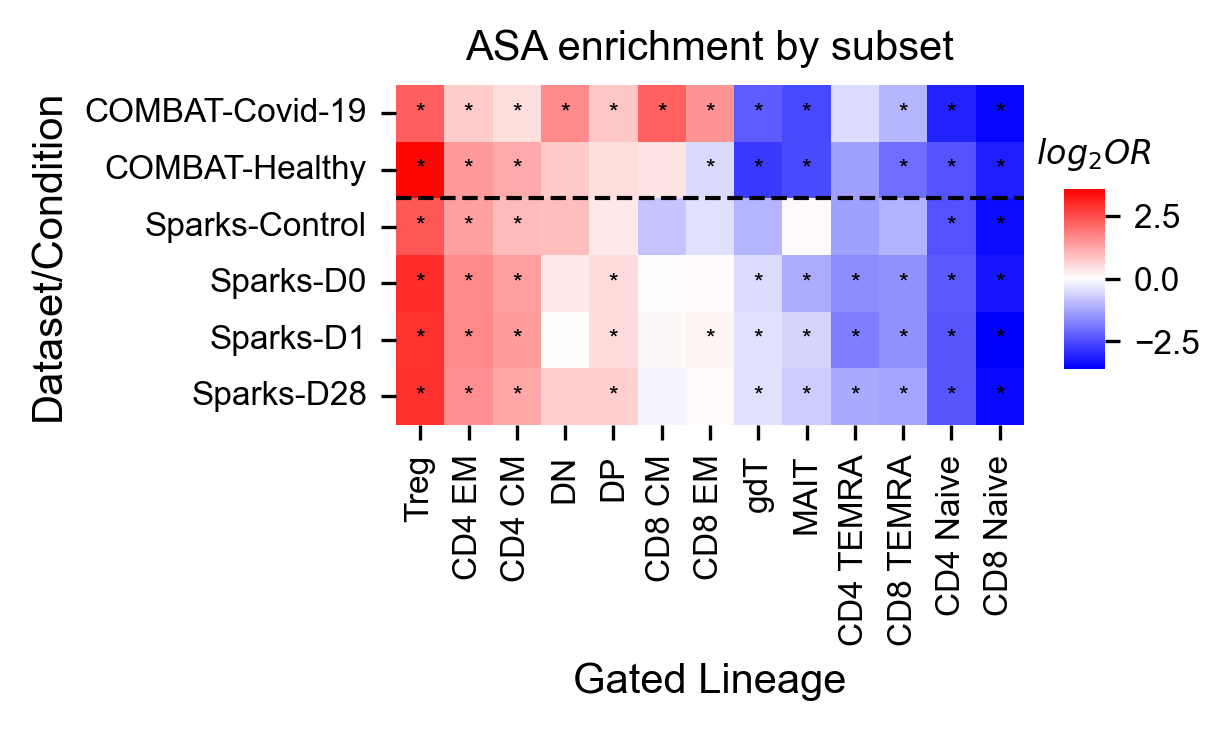

In [114]:
fig, ax = plt.subplots(dpi = 300, figsize = (2.7, 1.5), gridspec_kw={'right':.9})
cbar_ax = fig.add_axes([.95, 0.25, 0.05, 0.4])



g= sns.heatmap(lineage_logOR[lineage_order], 
            cmap = 'bwr', vmax = vmax, vmin = -vmax, ax=ax,
               annot = lineage_labels[lineage_order], fmt = 's', cbar_ax=cbar_ax,
               annot_kws = {'size' : 6, 'color' : 'black'}
              )

ax.hlines(2, 0, len(lineage_order), color = 'black', linewidth = 1, linestyle = 'dashed')
ax.set_ylabel('Dataset/Condition', fontsize = 10)
ax.set_xlabel('Gated Lineage', fontsize = 10)
ax.set_title('ASA enrichment by subset', fontsize = 10)

ax.set_xticks(np.arange(0+.5, len(lineage_order), 1), [x.replace('_', ' ') for x in lineage_order])
ax.tick_params('both', labelsize=8)
cbar_ax.tick_params('both', labelsize=8)
cbar_ax.set_title('  $log_{2} OR$', fontsize=8)

fig.savefig(os.path.join(figdir, 'Heatmap_ActivationScoreORByGatedLineage.png'), bbox_inches="tight")
fig.savefig(os.path.join(figdir, 'Heatmap_ActivationScoreORByGatedLineage.pdf'), bbox_inches="tight")

# Pan-cancer

In [328]:
dataset = 'Pan-Cancer'
individual_col = params.loc[dataset, 'individual_col']
sample_col = params.loc[dataset, 'sample_col']
count_fn = params.loc[dataset, 'raw_counts_filt_fn']
adata = sc.read(count_fn)

Only considering the two last: ['.20230927FiltForcNMF', '.h5ad'].
Only considering the two last: ['.20230927FiltForcNMF', '.h5ad'].


In [329]:
final_category = {'CD8.Tm':'CD8 Conv',
 'CD8.Tem':'CD8 Conv',
 'CD8.Trm':'CD8 Conv',
 'CD8.Tex':'CD8 Conv',
 'CD8.Temra':'CD8 Conv',
 'CD8.Tn':'CD8 Conv',
 'CD8.MAIT':'CD8 Conv',
 'CD8.Tk':'CD8 Conv',
 'CD8.ISG':'CD8 Conv',

 'CD4.Treg':'CD4 Treg',

 'CD4.Tm':'CD4 Conv',
 'CD4.Tn':'CD4 Conv',
 
 
 'CD4.Tfh':'CD4 Conv',
 'CD4.Th17':'CD4 Conv',
 'CD4.Tem':'CD4 Conv',
 'CD4.Temra':'CD4 Conv',
 'CD4.TfhTh1':'CD4 Conv',
 'CD4.Mix':'CD4 Conv',
 'CD4.ISG':'CD4 Conv'}

adata.obs['meta.cluster.short'] = adata.obs['meta.cluster'].apply(lambda x: '.'.join(np.array(x.split('.'))[[0, 2]]))
adata.obs['lineage'] = adata.obs['meta.cluster.short'].replace(final_category)

In [330]:
actinfo_filt['Pan-Cancer']['lineage'] = adata.obs.loc[actinfo_filt['Pan-Cancer'].index, 'lineage']

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


Text(0.5, 1.0, 'CD4 Conv')

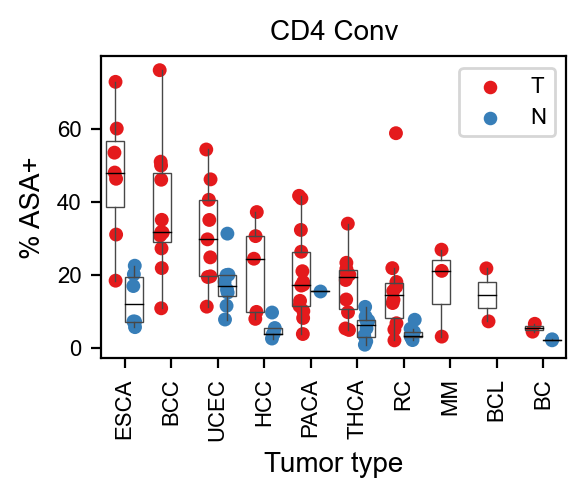

In [403]:
mincells = 20
mintumors = 2
dat = actinfo_filt['Pan-Cancer']
lineage = 'CD4 Conv'
readout = 'Activation_Status'



ind = (dat['lineage'] == lineage)
dat = dat.loc[ind, :]
dat[['individual', 'loc', 'cancerType']] = dat[['individual', 'loc', 'cancerType']].astype(str)
sample_stats = dat.groupby(['individual', 'loc', 'cancerType']).count()[readout].reset_index().rename(columns={'Activation_Status':'Ncell'})
num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
tumors_to_filt = num_tumors.index[num_tumors<mintumors]
dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

sample_average = (dat.groupby(['individual', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
sample_average = pd.merge(left=sample_average, right=sample_stats[['individual', 'Ncell']], on='individual', how='left')
sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]
order = list(sample_average.loc[sample_average['loc'] == 'T', :].groupby('cancerType')[readout].mean().sort_values(ascending=False).index)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)
sp = sns.stripplot(x='cancerType', y='Activation_Status', hue='loc', dodge=True, data=sample_average, order=order, hue_order=['T', 'N'], palette="Set1", ax=ax,
              zorder=-1)
sns.boxplot(x='cancerType', y=readout, data=sample_average, hue='loc', order=order, hue_order=['T', 'N'], palette="Set1", ax=ax,
            dodge=True, fliersize=0, showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, zorder=5)

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1,1), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.5)


ax.set_xticklabels(order, rotation=90)
ax.tick_params(labelsize=8)
ax.set_xlabel('Tumor type', fontsize=10)
ax.set_ylabel('% ASA+', fontsize=10)
ax.set_title(lineage, fontsize=10)

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


Text(0.5, 1.0, 'CD4 Conv')

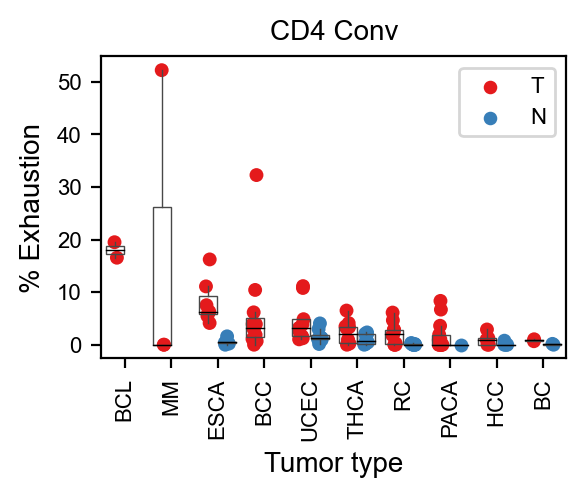

In [409]:
mincells = 20
mintumors = 2
dat = actinfo_filt['Pan-Cancer']
lineage = 'CD4 Conv'
readout = 'Exhaustion_Bin'



ind = (dat['lineage'] == lineage)
dat = dat.loc[ind, :]
dat[['individual', 'loc', 'cancerType']] = dat[['individual', 'loc', 'cancerType']].astype(str)
sample_stats = dat.groupby(['individual', 'loc', 'cancerType']).count()['Activation_Status'].reset_index().rename(columns={'Activation_Status':'Ncell'})
num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
tumors_to_filt = num_tumors.index[num_tumors<mintumors]
dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

sample_average = (dat.groupby(['individual', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
sample_average = pd.merge(left=sample_average, right=sample_stats[['individual', 'Ncell']], on='individual', how='left')
sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]
order = list(sample_average.loc[sample_average['loc'] == 'T', :].groupby('cancerType')[readout].mean().sort_values(ascending=False).index)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)
sp = sns.stripplot(x='cancerType', y=readout, hue='loc', dodge=True, data=sample_average, order=order, hue_order=['T', 'N'], palette="Set1", ax=ax,
              zorder=-1)
sns.boxplot(x='cancerType', y=readout, data=sample_average, hue='loc', order=order, hue_order=['T', 'N'], palette="Set1", ax=ax,
            dodge=True, fliersize=0, showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, zorder=5)

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1,1), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.5)


ax.set_xticklabels(order, rotation=90)
ax.tick_params(labelsize=8)
ax.set_xlabel('Tumor type', fontsize=10)
ax.set_ylabel('% Exhaustion', fontsize=10)
ax.set_title(lineage, fontsize=10)

In [448]:
actinfo_filt['Exhaustion_Usage']

,Activation_Score,Activation_Status,individual,sample,loc,cancerType,CellCycle_Usage,Exhaustion_Usage,CellCycle_Bin,Exhaustion_Bin,Pheno,Dataset,orig.individual,lineage,Pheno2
bcc.su001.pre.tcell_AAACGGGTCATACGGT-0,0.031491,False,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.002633,0.003581,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD4 Conv,Tumor
bcc.su001.pre.tcell_AAAGATGGTTTGGGCC-0,0.074126,True,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.034528,0.022445,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD4 Conv,Tumor
bcc.su001.pre.tcell_AAAGCAAAGCAGGTCA-0,0.180084,True,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.008120,0.003396,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD4 Conv,Tumor
bcc.su001.pre.tcell_AAAGTAGGTATATGAG-0,0.059935,False,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.010514,0.001775,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD4 Treg,Tumor
bcc.su001.pre.tcell_AAAGTAGGTCTGCCAG-0,0.447959,True,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.001467,0.001102,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD4 Treg,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGAACGTCGGCACT-88-29,0.037106,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.006088,0.018516,False,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv,Tumor
TTGGAACTCACTTACT-88-29,0.011973,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.000867,0.007465,False,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv,Tumor
TTTACTGAGACCACGA-88-29,0.058761,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.235870,0.042641,True,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv,Tumor
TTTATGCAGGCAATTA-88-29,0.001649,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.000937,0.001480,False,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv,Tumor


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


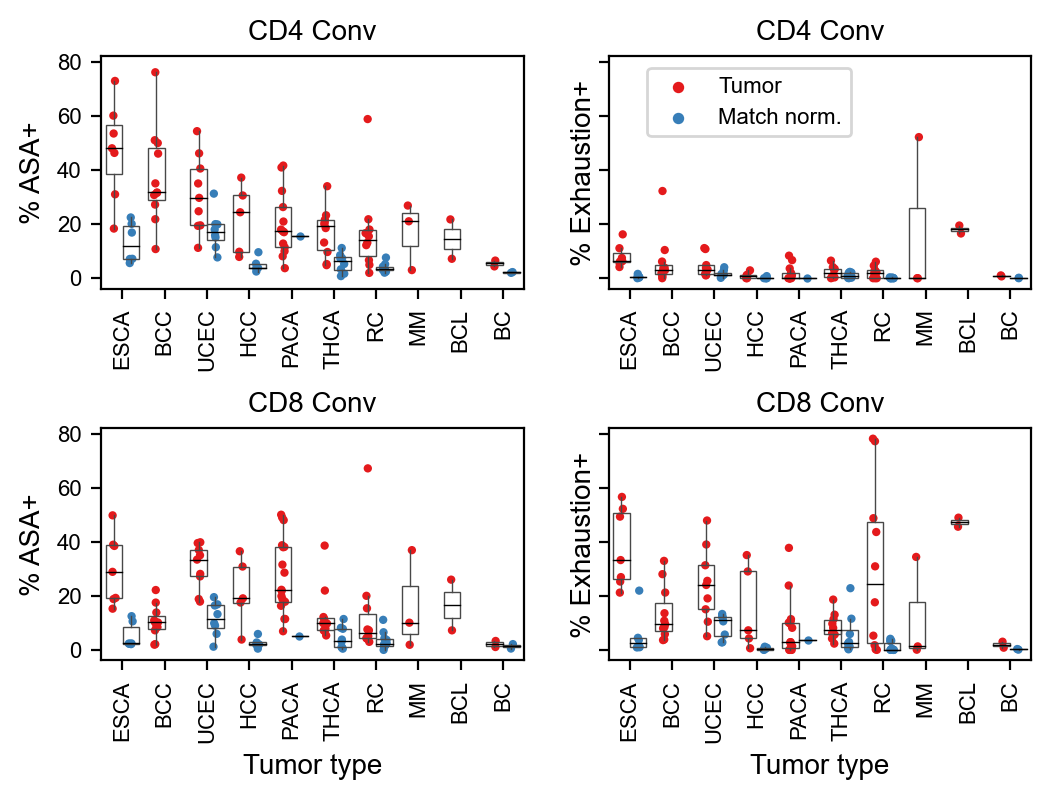

In [447]:
mincells = 20
mintumors = 2

(fig, axes) = plt.subplots(2,2, figsize=(6,4), dpi=200, gridspec_kw={'hspace':.6}, sharey=True)
count = 0 

for i,readout in enumerate(['Activation_Status', 'Exhaustion_Bin']):
    for j,lineage in enumerate(['CD4 Conv', 'CD8 Conv']):
        dat = actinfo_filt['Pan-Cancer'].copy()
        dat['Pheno2'] = dat['Pheno'].replace({'Cancer':'Tumor', 'Normal':'Match norm.'})
        
        
        ind = (dat['lineage'] == lineage)
        dat = dat.loc[ind, :]
        dat[['individual', 'Pheno2', 'cancerType']] = dat[['individual', 'Pheno2', 'cancerType']].astype(str)
        sample_stats = dat.groupby(['individual', 'Pheno2', 'cancerType']).count()['Activation_Status'].reset_index().rename(columns={'Activation_Status':'Ncell'})
        num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['Pheno2']=='Tumor'), 'cancerType'].value_counts()
        tumors_to_filt = num_tumors.index[num_tumors<mintumors]
        dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

        sample_average = (dat.groupby(['individual', 'Pheno2', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
        sample_average = pd.merge(left=sample_average, right=sample_stats[['individual', 'Ncell']], on='individual', how='left')
        sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]
        
        if count == 0:
            order = list(sample_average.loc[sample_average['Pheno2'] == 'Tumor', :].groupby('cancerType')[readout].mean().sort_values(ascending=False).index)

        ax = axes[j, i]
        sp = sns.stripplot(x='cancerType', y=readout, hue='Pheno2', dodge=True, data=sample_average, order=order, hue_order=['Tumor', 'Match norm.'],
                           palette="Set1", ax=ax, zorder=-1, s=3)
        sns.boxplot(x='cancerType', y=readout, data=sample_average, hue='Pheno2', order=order, hue_order=['Tumor', 'Match norm.'], palette="Set1", ax=ax,
            dodge=True, fliersize=0, showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, zorder=5)


        ax.set_xticklabels(order, rotation=90)
        ax.tick_params(labelsize=8)
        
        if j == 1:
            ax.set_xlabel('Tumor type', fontsize=10)
        else:
            ax.set_xlabel('', fontsize=10)
        
        if readout == 'Exhaustion_Bin':
            ax.set_ylabel('% Exhaustion+', fontsize=10)
        else:
            ax.set_ylabel('% ASA+', fontsize=10)
            
        if (i==1) and (j == 0):
            handles, labels = sp.get_legend_handles_labels()
            ax.legend(bbox_to_anchor=(0.6,1), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4)
        else:
            ax.legend_.remove()
                


        ax.set_title(lineage, fontsize=10)
        count += 1

        



In [426]:
dat

,Activation_Score,Activation_Status,individual,sample,loc,cancerType,CellCycle_Usage,Exhaustion_Usage,CellCycle_Bin,Exhaustion_Bin,Pheno,Dataset,orig.individual,lineage
bcc.su001.pre.tcell_AAAGATGAGACAGGCT-1,0.117525,True,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.006451,0.006918,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD8 Conv
bcc.su001.pre.tcell_AAAGCAAAGAGTTGGC-1,0.018304,False,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.001950,0.014591,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD8 Conv
bcc.su001.pre.tcell_AACCATGGTTATCGGT-1,0.016701,False,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.001258,0.007171,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD8 Conv
bcc.su001.pre.tcell_AACTCAGTCTTAGAGC-1,0.072167,True,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.003352,0.085062,False,True,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD8 Conv
bcc.su001.pre.tcell_AACTCTTGTGGTGTAG-1,0.000942,False,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.000161,0.000041,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD8 Conv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGAACGTCGGCACT-88-29,0.037106,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.006088,0.018516,False,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv
TTGGAACTCACTTACT-88-29,0.011973,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.000867,0.007465,False,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv
TTTACTGAGACCACGA-88-29,0.058761,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.235870,0.042641,True,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv
TTTATGCAGGCAATTA-88-29,0.001649,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.000937,0.001480,False,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv


In [413]:
actinfo_filt['Pan-Cancer']

,Activation_Score,Activation_Status,individual,sample,loc,cancerType,CellCycle_Usage,Exhaustion_Usage,CellCycle_Bin,Exhaustion_Bin,Pheno,Dataset,orig.individual,lineage
bcc.su001.pre.tcell_AAACGGGTCATACGGT-0,0.031491,False,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.002633,0.003581,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD4 Conv
bcc.su001.pre.tcell_AAAGATGGTTTGGGCC-0,0.074126,True,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.034528,0.022445,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD4 Conv
bcc.su001.pre.tcell_AAAGCAAAGCAGGTCA-0,0.180084,True,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.008120,0.003396,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD4 Conv
bcc.su001.pre.tcell_AAAGTAGGTATATGAG-0,0.059935,False,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.010514,0.001775,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD4 Treg
bcc.su001.pre.tcell_AAAGTAGGTCTGCCAG-0,0.447959,True,BCC.KathrynEYost2019.su001.T,bcc.su001.pre.tcell,T,BCC,0.001467,0.001102,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su001,CD4 Treg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGAACGTCGGCACT-88-29,0.037106,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.006088,0.018516,False,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv
TTGGAACTCACTTACT-88-29,0.011973,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.000867,0.007465,False,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv
TTTACTGAGACCACGA-88-29,0.058761,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.235870,0.042641,True,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv
TTTATGCAGGCAATTA-88-29,0.001649,False,UCEC.thisStudy.UCEC.P20190911.T,UCEC-P20190911-T,T,UCEC,0.000937,0.001480,False,False,Cancer,Pan-Cancer,UCEC.thisStudy.UCEC.P20190911,CD8 Conv


In [400]:
sample_average.loc[sample_average['loc'] == 'T', :].groupby('cancerType').mean()

,CellCycle_Bin,Activation_Status,Exhaustion_Bin,Ncell
cancerType,,,,
BC,0.591694,5.436878,0.848502,812.000000
BCC,4.098291,37.475350,6.037122,688.454545
BCL,0.871700,14.463350,18.014965,464.000000
ESCA,17.713141,47.204081,8.122256,627.428571
HCC,4.154129,21.971000,1.028356,311.200000
MM,2.603019,16.974431,17.398794,405.333333
PACA,8.269601,20.044434,1.730940,238.615385
RC,8.357042,16.975393,2.075757,548.700000
THCA,1.588588,17.111521,2.267830,904.200000


In [401]:
readout

'Activation_Score'

In [387]:
sample_stats

,individual,loc,cancerType,Ncell
0,BCC.KathrynEYost2019.su001.T,T,BCC,943
1,BCC.KathrynEYost2019.su002.T,T,BCC,65
2,BCC.KathrynEYost2019.su003.T,T,BCC,44
3,BCC.KathrynEYost2019.su004.T,T,BCC,213
4,BCC.KathrynEYost2019.su005.T,T,BCC,1167
...,...,...,...,...
131,UCEC.thisStudy.UCEC.P20190717.T,T,UCEC,196
132,UCEC.thisStudy.UCEC.P20190910.N,N,UCEC,96
133,UCEC.thisStudy.UCEC.P20190910.T,T,UCEC,656
134,UCEC.thisStudy.UCEC.P20190911.N,N,UCEC,675


In [379]:
sample_stats.loc[sample_stats['cancerType'].isin(tumors_to_filt), :]

,individual,loc,cancerType,Ncell
31,FTC.thisStudy.OV.P20181225.T,T,FTC,233
45,NSCLC.QianqianSong2019.P1.N,N,LUNG,111
46,NSCLC.QianqianSong2019.P1.T,T,LUNG,88
47,NSCLC.QianqianSong2019.P2.N,N,LUNG,5
48,NSCLC.QianqianSong2019.P2.T,T,LUNG,7
49,NSCLC.QianqianSong2019.P3.N,N,LUNG,9
50,NSCLC.QianqianSong2019.P4.N,N,LUNG,97
51,OV.thisStudy.OV.P20190304.N,N,OV,238
52,OV.thisStudy.OV.P20190304.T,T,OV,502


In [344]:
datcd4 = dat.loc[ind, :]
datcd4.loc[datcd4['individual']=='BCC.KathrynEYost2019.su003.T', :]

,Activation_Score,Activation_Status,individual,sample,loc,cancerType,CellCycle_Usage,Exhaustion_Usage,CellCycle_Bin,Exhaustion_Bin,Pheno,Dataset,orig.individual,lineage
bcc.su003.pre_CACTCCAAGACTTGAA-0,0.020006,False,BCC.KathrynEYost2019.su003.T,bcc.su003.pre,T,BCC,0.007713,0.003699,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su003,CD4 Conv
bcc.su003.pre_CAGCAGCGTACCGCTG-0,0.083474,True,BCC.KathrynEYost2019.su003.T,bcc.su003.pre,T,BCC,0.006671,0.002969,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su003,CD4 Conv
bcc.su003.pre_CTAGAGTCACACAGAG-0,0.066771,True,BCC.KathrynEYost2019.su003.T,bcc.su003.pre,T,BCC,0.001412,0.001921,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su003,CD4 Conv
bcc.su003.pre_CTAGAGTGTAGAAGGA-0,0.037518,False,BCC.KathrynEYost2019.su003.T,bcc.su003.pre,T,BCC,0.002302,0.001419,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su003,CD4 Conv
bcc.su003.pre_GAGCAGAGTGACTCAT-0,0.106256,True,BCC.KathrynEYost2019.su003.T,bcc.su003.pre,T,BCC,0.007569,0.001482,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su003,CD4 Conv
bcc.su003.pre_GTGTTAGTCTCATTCA-0,0.052082,False,BCC.KathrynEYost2019.su003.T,bcc.su003.pre,T,BCC,0.007208,0.006562,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su003,CD4 Conv
bcc.su003.pre_TAAACCGAGACCTAGG-0,0.063247,True,BCC.KathrynEYost2019.su003.T,bcc.su003.pre,T,BCC,0.005738,0.039526,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su003,CD4 Conv
bcc.su003.pre_TGAGAGGTCGTATCAG-0,0.042957,False,BCC.KathrynEYost2019.su003.T,bcc.su003.pre,T,BCC,0.004812,0.007802,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su003,CD4 Conv
bcc.su003.pre_TTGCGTCCACGGTAGA-0,0.148913,True,BCC.KathrynEYost2019.su003.T,bcc.su003.pre,T,BCC,0.005782,0.001185,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su003,CD4 Conv
bcc.su003.post.tcell.cd45_AAACGGGCACGGTAGA-0,0.053839,False,BCC.KathrynEYost2019.su003.T,bcc.su003.post.tcell.cd45,T,BCC,0.005143,0.005519,False,False,Cancer,Pan-Cancer,BCC.KathrynEYost2019.su003,CD4 Conv


In [332]:
count.shape

(136,)

# Covid-19

<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

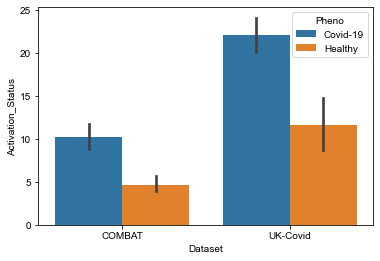

In [221]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Y = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
merged = pd.concat([X, Y], axis=0)

ind = (merged['Gating_Simple']=='conv')


sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']
sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)


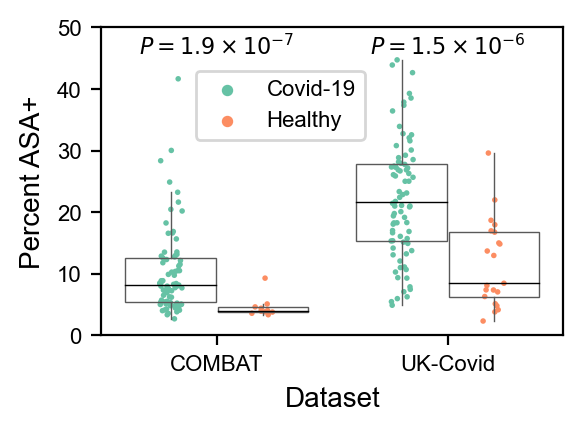

In [222]:
(fig,ax) = plt.subplots(1,1, figsize=(3, 2), dpi=200, gridspec_kw={'left':.2, 'bottom':.2, 'top':.97, 'right':.97})

ind = (sample_average['Ncells']>100)

sp = sns.stripplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average.loc[ind, :], dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Dataset', y='Activation_Status', data=sample_average.loc[ind, :], hue='Pheno', dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, ax=ax, zorder=5)
bp.legend_.remove()

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(.18,.6), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4)
ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_xlabel('Dataset', fontsize=10)

ax.set_ylim([0, 50])

a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)
P_sci_notation = f"{P:.1e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting


ax.text(0, 47, r'$P = {:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8, ha='center', va='center')


a = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)
P_sci_notation = f"{P:.2e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting

ax.text(1, 47, r'$P = {:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8, ha='center', va='center')

ax.tick_params(labelsize=8)

plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.png'))
plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.pdf'))

In [225]:
a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
a.mean(), a.min(), a.max()

(10.283471853776794, 2.699683485384472, 41.662183969876274)

In [227]:
a = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
a.mean(), a.min(), a.max()

(22.166259014197475, 4.90506329113924, 44.73503097040606)

<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

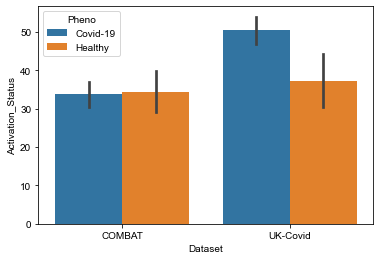

In [232]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Y = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
merged = pd.concat([X, Y], axis=0)

ind = (merged['Gating_Simple']=='Treg')


sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']
sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)

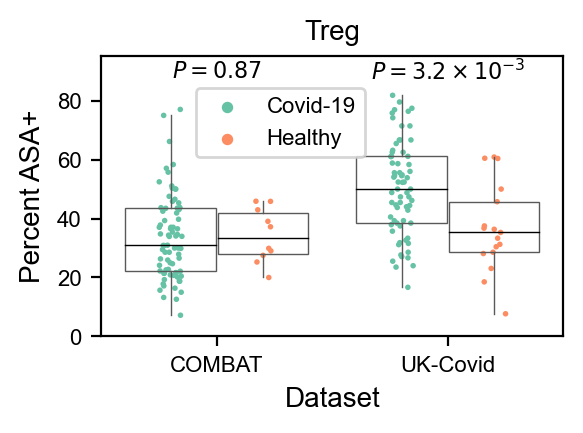

In [233]:
(fig,ax) = plt.subplots(1,1, figsize=(3, 2), dpi=200, gridspec_kw={'left':.2, 'bottom':.2, 'top':.9, 'right':.97})

ind = (sample_average['Ncells']>10)

sp = sns.stripplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average.loc[ind, :], dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Dataset', y='Activation_Status', data=sample_average.loc[ind, :], hue='Pheno', dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, ax=ax, zorder=5)
bp.legend_.remove()

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(.18,.6), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4)
ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_xlabel('Dataset', fontsize=10)
ax.set_title('Treg', fontsize=10)

ax.set_ylim([0, 95])

a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)

ax.text(0, 90, r'$P = {:.2f}$'.format(P), fontsize=8, ha='center', va='center')


a = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
T,P = ttest_ind(a,b, equal_var=False)
P_sci_notation = f"{P:.2e}"
base, exponent = P_sci_notation.split("e")
exponent = int(exponent)  # Convert exponent to integer for clean formatting

ax.text(1, 90, r'$P = {:.1f} \times 10^{{{}}}$'.format(float(base), exponent), fontsize=8, ha='center', va='center')

ax.tick_params(labelsize=8)

plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.Treg.png'))
plt.savefig(os.path.join(figdir, 'CovidVsActivation.Stripplot.Treg.pdf'))

In [234]:
a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
a.mean(), a.min(), a.max()

(34.265491721046956, 20.0, 45.87155963302752)

In [235]:
a = sample_average.loc[(sample_average['Dataset']=='UK-Covid') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
a.mean(), a.min(), a.max()

(37.12753382132898, 0.0, 62.5)

<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

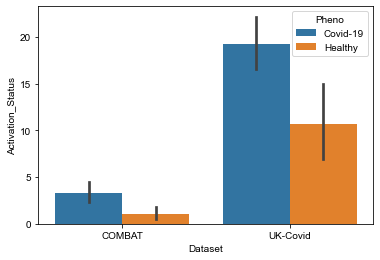

In [231]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Y = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
merged = pd.concat([X, Y], axis=0)

ind = merged['Gating'].isin(['gdT', 'MAIT'])


sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']
sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)

In [230]:
merged

,Activation_Status,individual,CellCycle_Bin,Gating,Pheno,Gating_Simple,Dataset
AAACCTGAGCGGATCA-1-gPlexA1,False,S00112,False,CD8_EM,Covid-19,conv,COMBAT
AAACCTGCAGCTCGAC-1-gPlexA1,False,S00005,False,CD4_CM,Covid-19,conv,COMBAT
AAACCTGCATCTATGG-1-gPlexA1,False,H00067,False,CD4_EM,Healthy,conv,COMBAT
AAACCTGGTCTCTCTG-1-gPlexA1,True,N00027,False,CD4_CM,NaN,conv,COMBAT
AAACCTGTCACCGGGT-1-gPlexA1,True,U00515,False,CD8_TEMRA,Covid-19,conv,COMBAT
...,...,...,...,...,...,...,...
BGCV15_TTTCCTCTCTTTAGGG-1,False,CV0944,False,CD4_Memory,Healthy,conv,UK-Covid
BGCV15_TTTGCGCAGCGAAGGG-1,False,CV0176,False,CD4_Naive,Covid-19,conv,UK-Covid
BGCV15_TTTGGTTGTTGGGACA-1,True,CV0176,False,CD4_Memory,Covid-19,conv,UK-Covid
BGCV15_TTTGTCACAGACACTT-1,False,CV0257,False,CD8_EM,Covid-19,conv,UK-Covid


In [195]:
T,P = ttest_ind(a,b, equal_var=False)


In [196]:
P

0.0031953058165509517

In [164]:
base

'1.76'

Text(0.5, 1.0, 'Treg')

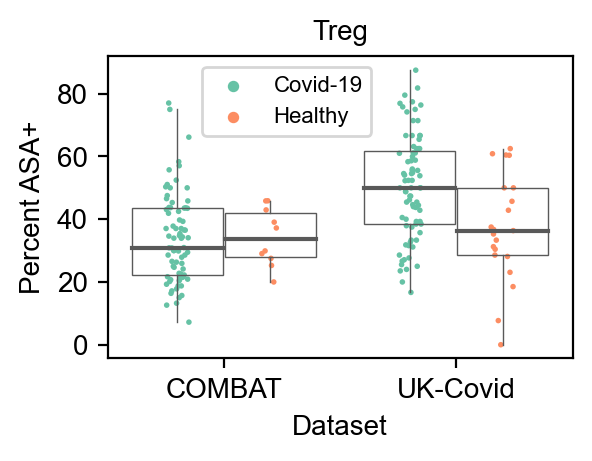

In [157]:
ind = (merged['Gating_Simple']=='Treg')
sample_average = (merged.loc[ind,:].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
(fig,ax) = plt.subplots(1,1, figsize=(3, 2), dpi=200)
sp = sns.stripplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average, dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Dataset', y='Activation_Status', data=sample_average, hue='Pheno', dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, ax=ax, zorder=5)
bp.legend_.remove()

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(.18,.7), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.4)
ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_title('Treg', fontsize=10)

# Vaccine

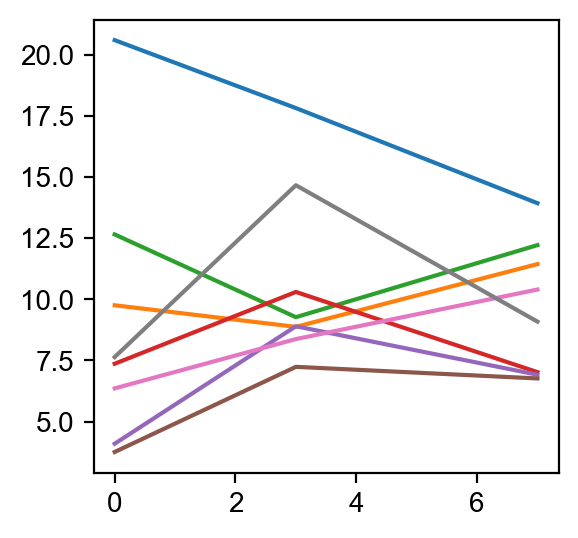

In [99]:
merged = actinfo['HIV-Vaccine'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']].dropna()
ind = (merged['Gating_Simple']!='Treg')

sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index().dropna()
sample_average_perday = sample_average.pivot_table(index='individual', columns='Pheno', values='Activation_Status')
sample_average_perday.columns = [0, 3, 7]

(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
for i in sample_average_perday.index:
    ax.plot(sample_average_perday.columns, sample_average_perday.loc[i, :])

Text(0.5, 1.0, 'HIV vaccine')

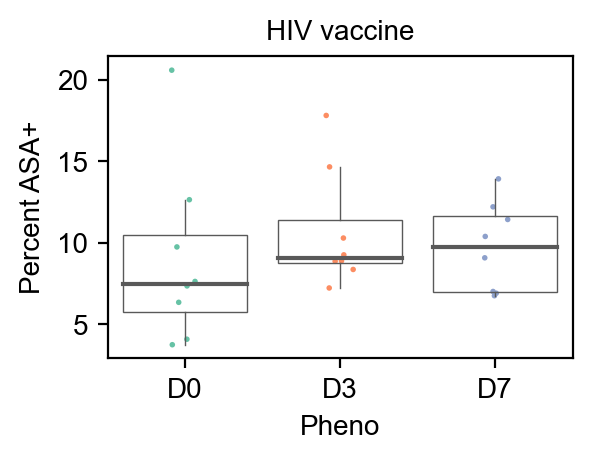

In [125]:
merged = actinfo['HIV-Vaccine']
ind = (merged['Gating_Simple']!='Treg')
sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index().dropna()
sample_average = sample_average.loc[sample_average['individual'] != 'Control', :]


(fig,ax) = plt.subplots(1,1, figsize=(3, 2), dpi=200)
sp = sns.stripplot(x='Pheno', y='Activation_Status', data=sample_average, dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Pheno', y='Activation_Status', data=sample_average,  dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, ax=ax, zorder=5)

ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_title('HIV vaccine', fontsize=10)

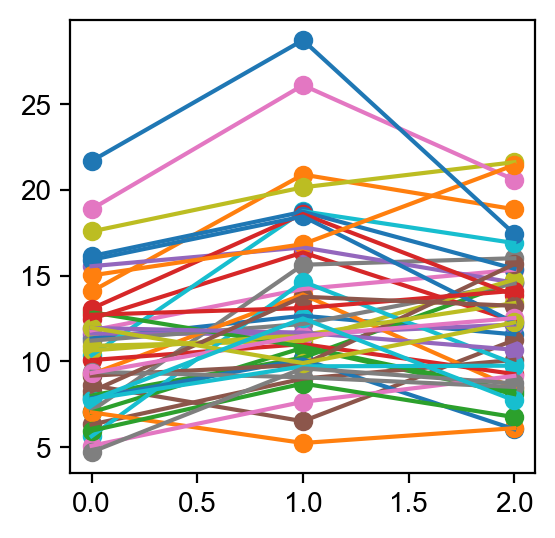

In [118]:
merged = actinfo['Sparks']
ind = (merged['Gating_Simple']!='Treg')
sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index().dropna()



sample_average_perday = sample_average.pivot_table(index='individual', columns='Pheno', values='Activation_Status').drop('Control', axis=1)
sample_average_perday_norm = sample_average_perday.copy()
sample_average_perday_norm.columns = [0, 1, 2]
sample_average_perday_norm = sample_average_perday_norm.div(sample_average_perday_norm[0], axis=0)


(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
for i in sample_average_perday_norm.index:
    ax.scatter([0,1,2], sample_average_perday.loc[i, :])
    ax.plot([0,1,2], sample_average_perday.loc[i, :])




Text(0.5, 1.0, 'Flu vaccine')

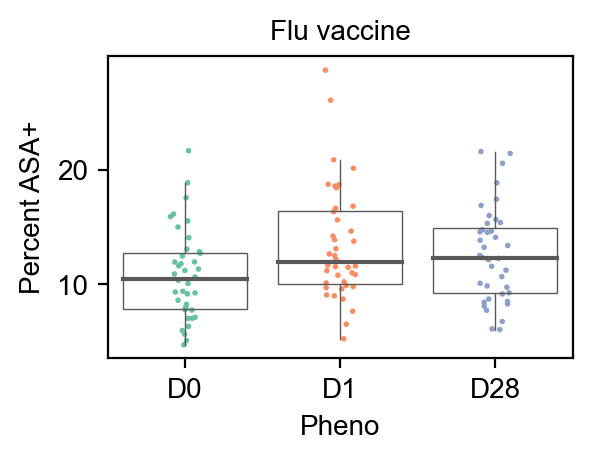

In [123]:
merged = actinfo['Sparks']
ind = (merged['Gating_Simple']!='Treg')
sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index().dropna()
sample_average = sample_average.loc[sample_average['individual'] != 'Control', :]


(fig,ax) = plt.subplots(1,1, figsize=(3, 2), dpi=200)
sp = sns.stripplot(x='Pheno', y='Activation_Status', data=sample_average, dodge=True, ax=ax, palette="Set2", zorder=-1, s=2)

bp = sns.boxplot(x='Pheno', y='Activation_Status', data=sample_average,  dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, ax=ax, zorder=5)

ax.set_ylabel('Percent ASA+', fontsize=10)
ax.set_title('Flu vaccine', fontsize=10)

<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

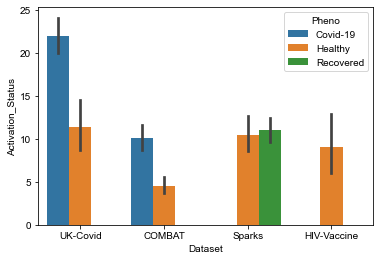

In [148]:
X = actinfo_filt['COMBAT'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Y = actinfo_filt['UK-Covid'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Z = actinfo['Sparks'].loc[(actinfo['Sparks']['Pheno']=='D0'), ['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
Z['Pheno'] = Z['individual'].apply(lambda x: x.split('-')[0]).replace({'COVR':'Recovered', 'HC':'Healthy'})
A = actinfo['HIV-Vaccine'].loc[(actinfo['HIV-Vaccine']['Pheno']=='D0'), ['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']]
A['Pheno'] = 'Healthy'

merged = pd.concat([X, Y, Z, A], axis=0)

ind = (merged['Gating_Simple']!='Treg')


sample_average = (merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sample_average.index = sample_average['individual']
count = merged.loc[ind, :].groupby(['Dataset', 'Pheno', 'individual']).count()['Activation_Status'].reset_index()
count.index = count['individual']
sample_average['Ncells'] = count.loc[sample_average.index, 'Activation_Status']
sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average, order=['UK-Covid', 'COMBAT', 'Sparks', 'HIV-Vaccine'])

Ttest_indResult(statistic=5.9794146576755525, pvalue=1.763297625317448e-07)

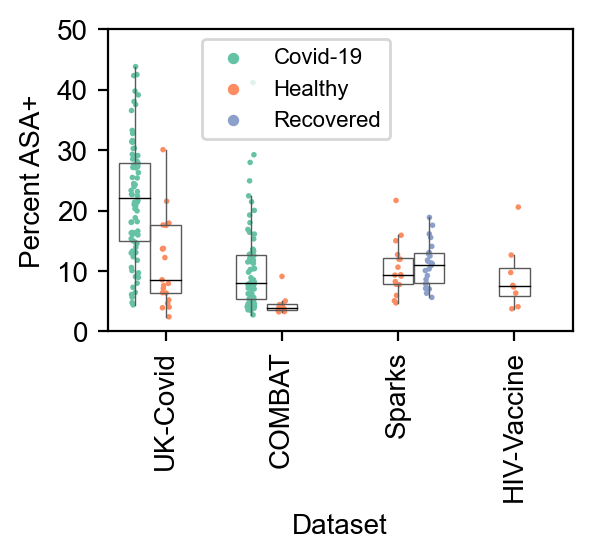

In [152]:
(fig,ax) = plt.subplots(1,1, figsize=(3, 2), dpi=200)

ind = (sample_average['Ncells']>100)

sp = sns.stripplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average.loc[ind, :], dodge=True, ax=ax, palette="Set2", zorder=-1, s=2,
                  order=['UK-Covid', 'COMBAT', 'Sparks', 'HIV-Vaccine'])

bp = sns.boxplot(x='Dataset', y='Activation_Status', data=sample_average, hue='Pheno', dodge=True, fliersize=0, palette="Set2", showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, ax=ax, zorder=5,
                order=['UK-Covid', 'COMBAT', 'Sparks', 'HIV-Vaccine'])
bp.legend_.remove()

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(.18,.6), handles=handles[:3], labels=labels[:3], fontsize=8, markerscale=.4)
ax.set_ylabel('Percent ASA+')
ax.set_ylim([0, 50])
ax.set_xticklabels(['UK-Covid', 'COMBAT', 'Sparks', 'HIV-Vaccine'], rotation=90)

a = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Covid-19'), 'Activation_Status']
b = sample_average.loc[(sample_average['Dataset']=='COMBAT') & (sample_average['Pheno']=='Healthy'), 'Activation_Status']
ttest_ind(a,b, equal_var=False)
#ax.text(0, 45, 'P=%.2f'%

<AxesSubplot:xlabel='Pheno', ylabel='Activation_Status'>

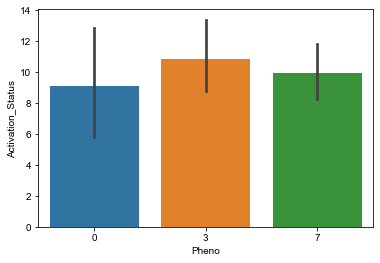

In [283]:
merged = actinfo['HIV-Vaccine'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset']].dropna()
sample_average = (merged.groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index().dropna()
sns.barplot(x='Pheno', y='Activation_Status', data=sample_average)

In [285]:
actinfo['HIV-Vaccine']['time']

L1_AAACCCAAGACATACA      7
L1_AAACCCACAACTGGTT      3
L1_AAACCCACAGCATACT      7
L1_AAACCCACATCAGTCA      3
L1_AAACCCATCCACACCT      3
                        ..
E2L8_TTTGGTTTCGTCAACA    0
E2L8_TTTGTTGAGGCATGCA    7
E2L8_TTTGTTGAGTAGAGTT    3
E2L8_TTTGTTGCAGCGTGAA    3
E2L8_TTTGTTGGTCGTGATT    7
Name: time, Length: 73259, dtype: category
Categories (3, object): ['0', '3', '7']

<AxesSubplot:xlabel='group', ylabel='Activation_Status'>

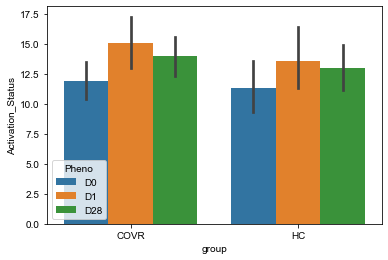

In [264]:
merged = actinfo['Sparks'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset', 'group']].dropna()
sample_average = (merged.groupby(['Dataset', 'Pheno', 'individual', 'group']).mean()*100).reset_index().dropna()
sns.barplot(x='group', hue='Pheno', y='Activation_Status', data=sample_average)

<AxesSubplot:xlabel='group', ylabel='Activation_Status'>

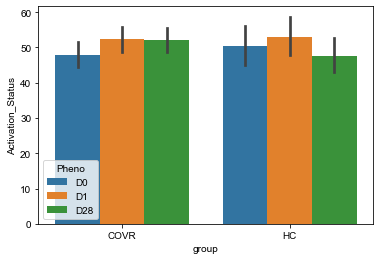

In [266]:
merged = actinfo['Sparks'][['Activation_Status', 'individual', 'CellCycle_Bin', 'Gating', 'Pheno', 'Gating_Simple', 'Dataset', 'group']].dropna()
sample_average = (merged.loc[merged['Gating_Simple']=='Treg', :].groupby(['Dataset', 'Pheno', 'individual', 'group']).mean()*100).reset_index().dropna()
sns.barplot(x='group', hue='Pheno', y='Activation_Status', data=sample_average)

In [259]:
sample_average

,Dataset,Pheno,individual,Activation_Status,CellCycle_Bin
24,Sparks,Control,Control,0.102371,0.001715
41,Sparks,D0,COVR-2,0.124497,0.002683
42,Sparks,D0,COVR-4,0.148873,0.003694
43,Sparks,D0,COVR-6,0.086614,0.003500
44,Sparks,D0,COVR-8,0.135541,0.003073
...,...,...,...,...,...
159,Sparks,D28,HC-34,0.137694,0.003442
160,Sparks,D28,HC-35,0.094948,0.002508
161,Sparks,D28,HC-37,0.130405,0.002421
162,Sparks,D28,HC-38,0.082228,0.003316


<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

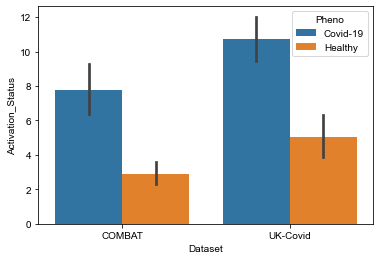

<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

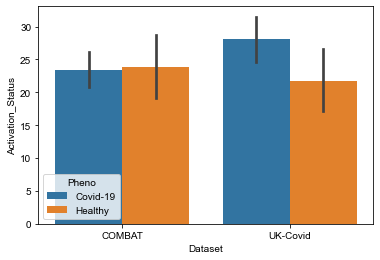

In [181]:
sample_average = (merged.loc[merged['Gating_Simple']=='Treg', :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)

<AxesSubplot:xlabel='Dataset', ylabel='Activation_Status'>

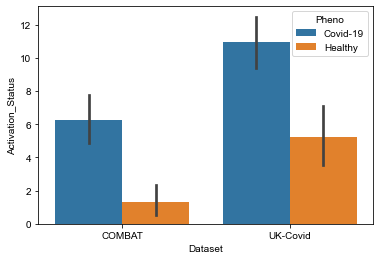

In [184]:
sample_average = (merged.loc[merged['Gating_Simple']=='unconv', :].groupby(['Dataset', 'Pheno', 'individual']).mean()*100).reset_index()
sns.barplot(x='Dataset', y='Activation_Status', hue='Pheno', data=sample_average)

In [183]:
merged['Gating_Simple'].value_counts()

conv      591397
unconv     67185
Treg       14533
Name: Gating_Simple, dtype: int64

In [182]:
sample_average

,Dataset,Pheno,individual,Activation_Status,CellCycle_Bin
0,COMBAT,Covid-19,G05061,15.447154,0.813008
1,COMBAT,Covid-19,G05064,25.000000,0.694444
2,COMBAT,Covid-19,G05073,4.316547,0.000000
3,COMBAT,Covid-19,G05077,10.810811,2.702703
4,COMBAT,Covid-19,G05078,17.699115,7.964602
...,...,...,...,...,...
182,UK-Covid,Healthy,MH8919283,13.043478,4.347826
183,UK-Covid,Healthy,MH8919332,34.883721,0.000000
184,UK-Covid,Healthy,MH8919333,21.875000,0.000000
185,UK-Covid,Healthy,newcastle65,30.188679,0.000000


In [ ]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(activation[individual_col], activation[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)


tofilt = activation[individual_col].isin(tokeep.index) & ~activation[sample_col].isin(tokeep.values)
activation_filt = activation.loc[~tofilt, :]

ct = pd.crosstab(activation_filt[individual_col], activation_filt[sample_col])
(ct>0).sum(axis=1).value_counts()

In [156]:
actinfo['COMBAT']

,Activation_Score,Activation_Status,individual,sample,Source,TimeSinceOnset,CellCycle_Usage,CellCycle_Bin,Gating,Pheno,Gating_Simple
AAACCTGAGCGGATCA-1-gPlexA1,0.046550,False,S00112,S00112-Ja003,COVID_MILD,12.0,1.054688e-03,False,CD8_EM,Covid-19,conv
AAACCTGCAGCTCGAC-1-gPlexA1,0.013070,False,S00005,S00005-Ja005,COVID_CRIT,14.0,3.612664e-03,False,CD4_CM,Covid-19,conv
AAACCTGCATCTATGG-1-gPlexA1,0.011637,False,H00067,H00067-Ha001,HV,NaN,2.010103e-03,False,CD4_EM,Healthy,conv
AAACCTGGTCTCTCTG-1-gPlexA1,0.020845,False,N00027,N00027-Ja001,Sepsis,9.0,6.916480e-03,False,CD4_CM,NaN,conv
AAACCTGTCACCGGGT-1-gPlexA1,0.055559,False,U00515,U00515-Ua005,COVID_LDN,15.0,1.743664e-03,False,CD8_TEMRA,Covid-19,conv
...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCTCAACC-1-gPlexK7,0.003608,False,S00048,S00048-Ja003,COVID_SEV,12.0,1.342514e-03,False,CD4_Naive,Covid-19,conv
TTTGGTTTCTCGATGA-1-gPlexK7,0.015328,False,N00038,N00038-Ja001,Sepsis,7.0,4.536087e-03,False,CD4_CM,NaN,conv
TTTGTCACACCACGTG-1-gPlexK7,0.003144,False,S00057,S00057-Ja003,COVID_SEV,10.0,7.268757e-05,False,CD8_TEMRA,Covid-19,conv
TTTGTCAGTTACCGAT-1-gPlexK7,0.002599,False,U00501,U00501-Ua005,Flu,11.0,7.784450e-04,False,CD8_EM,NaN,conv


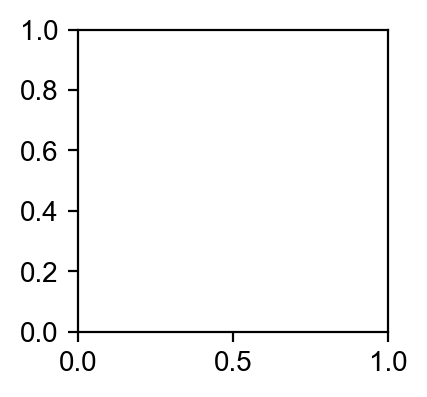

In [154]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)

Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].
Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].


In [121]:


activation['Gating_Simple'].value_counts()

conv      374278
unconv     13576
Treg       11745
Name: Gating_Simple, dtype: int64

In [122]:
ct = pd.crosstab([activation['Pheno'], activation['Gating_Simple']], activation['Activation_Status'].astype(str))
covidsum = ct.loc['Covid-19', :].sum().sum()
healthysum = ct.loc['Healthy', :].sum().sum()
ctfrac = ct.loc[:, 'True'].reset_index()
ctfrac.loc[ctfrac['Pheno'] == 'Covid-19', 'True'] /= covidsum
ctfrac.loc[ctfrac['Pheno'] == 'Healthy', 'True'] /= healthysum
ctfrac

,Pheno,Gating_Simple,True
0,Covid-19,Treg,0.007033
1,Covid-19,conv,0.063316
2,Covid-19,unconv,0.001318
3,Healthy,Treg,0.005114
4,Healthy,conv,0.023203
5,Healthy,unconv,0.000395


In [123]:
ct = pd.crosstab(activation['Pheno'], activation['Activation_Status'].astype(str))
ct.div(ct.sum(axis=1), axis=0)

Activation_Status,False,True
Pheno,,
Covid-19,0.928333,0.071667
Healthy,0.971288,0.028712


In [129]:
## For individuals with multiple samples, filter the sample with fewer cells
ct = pd.crosstab(activation[individual_col], activation[sample_col])
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)


tofilt = activation[individual_col].isin(tokeep.index) & ~activation[sample_col].isin(tokeep.values)
activation_filt = activation.loc[~tofilt, :]

ct = pd.crosstab(activation_filt[individual_col], activation_filt[sample_col])
(ct>0).sum(axis=1).value_counts()

1    109
2     10
3      3
dtype: int64

1    122
dtype: int64

<AxesSubplot:xlabel='Pheno', ylabel='Activation_Status'>

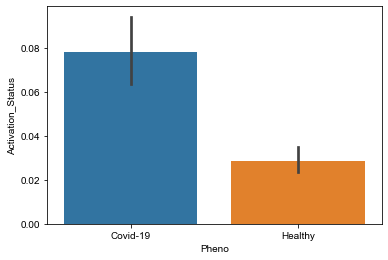

In [143]:
activation_frac = pd.DataFrame(activation_filt.groupby('COMBAT_ID')['Activation_Status'].mean())
ncells = activation_filt.groupby('COMBAT_ID')['Activation_Status'].count()
activation_frac['Ncell'] = ncells.loc[activation_frac.index]

activation_frac = pd.merge(left=activation_frac, right=activation_filt[['COMBAT_ID','COMBAT_participant_timepoint_ID','Source','TimeSinceOnset', 'Pheno']].drop_duplicates(),
         left_index=True, right_on='COMBAT_ID', how='left')

sns.barplot(x='Pheno', y='Activation_Status', data=activation_frac, ci=95)

In [ ]:
activation_frac = pd.DataFrame(activation_filt.groupby('COMBAT_ID')['Activation_Status'].mean())
ncells = activation_filt.groupby('COMBAT_ID')['Activation_Status'].count()
activation_frac['Ncell'] = ncells.loc[activation_frac.index]

activation_frac = pd.merge(left=activation_frac, right=activation_filt[['COMBAT_ID','COMBAT_participant_timepoint_ID','Source','TimeSinceOnset', 'Pheno']].drop_duplicates(),
         left_index=True, right_on='COMBAT_ID', how='left')

sns.barplot(x='Pheno', y='Activation_Status', data=activation_frac, ci=95)

In [145]:
activation_filt['Gating_Simple']

AAACCTGAGCGGATCA-1-gPlexA1    conv
AAACCTGCAGCTCGAC-1-gPlexA1    conv
AAACCTGCATCTATGG-1-gPlexA1    conv
AAACCTGGTCTCTCTG-1-gPlexA1    conv
AAACCTGTCACCGGGT-1-gPlexA1    conv
                              ... 
TTTGGTTTCCTCAACC-1-gPlexK7    conv
TTTGGTTTCTCGATGA-1-gPlexK7    conv
TTTGTCACACCACGTG-1-gPlexK7    conv
TTTGTCAGTTACCGAT-1-gPlexK7    conv
TTTGTCATCCTCTAGC-1-gPlexK7    conv
Name: Gating_Simple, Length: 364949, dtype: object

In [127]:
activation

,Activation_Score,Activation_Status,TCR_clone_ID,COMBAT_ID,COMBAT_participant_timepoint_ID,Source,TimeSinceOnset,CellCycle_Usage,CellCycle_Bin,Gating,Pheno,Gating_Simple
AAACCTGAGCGGATCA-1-gPlexA1,0.046550,False,TRA_CAVGDQTGANNLFF-TRB_CASSLRSGTSYF,S00112,S00112-Ja003,COVID_MILD,12.0,1.054688e-03,False,CD8_EM,Covid-19,conv
AAACCTGCAGCTCGAC-1-gPlexA1,0.013070,False,TRA_CADNFNKFYF-TRB_CASSESPGHSPLHF,S00005,S00005-Ja005,COVID_CRIT,14.0,3.612664e-03,False,CD4_CM,Covid-19,conv
AAACCTGCATCTATGG-1-gPlexA1,0.011637,False,TRA_CAVREAAGNKLTF-TRB_CASSEQGSSYEQYF,H00067,H00067-Ha001,HV,NaN,2.010103e-03,False,CD4_EM,Healthy,conv
AAACCTGGTCTCTCTG-1-gPlexA1,0.020845,False,TRA_CAAIILKAGNNRKLIW-TRB_CASSLPGQISSSYTF,N00027,N00027-Ja001,Sepsis,9.0,6.916480e-03,False,CD4_CM,NaN,conv
AAACCTGTCACCGGGT-1-gPlexA1,0.055559,False,TRA_CAMTPGGGADGLTF-TRB_CASGIGGLGNTEAFF,U00515,U00515-Ua005,COVID_LDN,15.0,1.743664e-03,False,CD8_TEMRA,Covid-19,conv
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCTCAACC-1-gPlexK7,0.003608,False,TRA_CAVDMKVYSGGGADGLTF-TRB_CSAPRLAGGWWETQYF,S00048,S00048-Ja003,COVID_SEV,12.0,1.342514e-03,False,CD4_Naive,Covid-19,conv
TTTGGTTTCTCGATGA-1-gPlexK7,0.015328,False,TRA_CARWAGGFKTIF-TRB_CASSSPGLGDEQFF,N00038,N00038-Ja001,Sepsis,7.0,4.536087e-03,False,CD4_CM,NaN,conv
TTTGTCACACCACGTG-1-gPlexK7,0.003144,False,TRA_CAFEPNSGYALNF-TRB_CASSPETYEQYF,S00057,S00057-Ja003,COVID_SEV,10.0,7.268757e-05,False,CD8_TEMRA,Covid-19,conv
TTTGTCAGTTACCGAT-1-gPlexK7,0.002599,False,TRB_CASSLRVSNQPQHF,U00501,U00501-Ua005,Flu,11.0,7.784450e-04,False,CD8_EM,NaN,conv


In [124]:
cellthresh=100
res = []
for (k,g) in activation.groupby('TimeSinceOnset'):
    for k2, g2, in g.groupby('COMBAT_participant_timepoint_ID'):
        if g2.shape[0]>cellthresh:
            n = g2.shape[0]
            frac = g2['Activation_Status'].mean()
            res.append([k, k2, n, frac])
        
res = pd.DataFrame(res)
res.head()

,0,1,2,3
0,0.0,N00024-Ja001,5667,0.055409
1,0.0,N00028-Ja001,2772,0.064574
2,0.0,N00033-Ja001,3314,0.044659
3,1.0,N00040-Ja001,543,0.071823
4,1.0,U00605-Ua005,232,0.025862


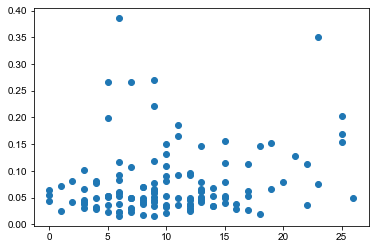

In [125]:
plt.scatter(res[0], res[3])

In [126]:
spearmanr(res[0], res[3])

SpearmanrResult(correlation=0.17229204884879915, pvalue=0.052752006566204414)

# UK-Covid

In [95]:
dataset = 'UK-Covid'
individual_col = params.loc[dataset, 'individual_col']
sample_col = params.loc[dataset, 'sample_col']

In [96]:
count_fn = params.loc[dataset, 'raw_counts_filt_fn']
adata = sc.read(count_fn)

Only considering the two last: ['.ADTfixedADT_70FiltForcNMF', '.h5ad'].
Only considering the two last: ['.ADTfixedADT_70FiltForcNMF', '.h5ad'].


In [104]:
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

In [108]:
activation = pd.read_csv(params.loc[dataset, 'activation_score_fn'], index_col = 0, sep = '\t')
activation_score = activation['Activation_Score']
activation['Activation_Status'] = activation['Activation_Score'] > activation_threshold
activation = pd.merge(left=activation, right=adata.obs[[ individual_col, sample_col, 'Status_on_day_collection_summary', 'Days_from_onset']], how='left', left_index=True, right_index=True)
activation['CellCycle_Usage'] = usage_norm.loc[activation.index, cc_geps].sum(axis=1)
activation['CellCycle_Bin'] = activation['CellCycle_Usage']>activation_threshold
gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], sep='\t', index_col=0)['0']
activation['Gating'] = gating.loc[activation.index]
activation['Pheno'] = activation[phenomap[dataset]['col']].replace(phenomap[dataset]['mapping'])

In [110]:
convs = ['CD4_Naive', 'CD4_CM', 'CD4_EM', 'CD8_TEMRA', 'CD8_EM', 'CD8_Naive',
       'DP', 'CD8_CM', 'CD4_TEMRA', 'CD4_Memory']
regs = ['Treg']
unconv = ['gdT', 'MAIT', 'DN']
mapping = dict(zip(convs + regs + unconv, ['conv']*len(convs) + ['Treg']*len(regs) + ['unconv']*len(unconv)))

activation['Gating_Simple'] = activation['Gating'].replace(mapping)
activation['Gating_Simple'].value_counts()

conv      217119
unconv     53609
Treg        2788
Name: Gating_Simple, dtype: int64

In [111]:
ct = pd.crosstab([activation['Pheno'], activation['Gating_Simple']], activation['Activation_Status'].astype(str))
covidsum = ct.loc['Covid-19', :].sum().sum()
healthysum = ct.loc['Healthy', :].sum().sum()
ctfrac = ct.loc[:, 'True'].reset_index()
ctfrac.loc[ctfrac['Pheno'] == 'Covid-19', 'True'] /= covidsum
ctfrac.loc[ctfrac['Pheno'] == 'Healthy', 'True'] /= healthysum
ctfrac

,Pheno,Gating_Simple,True
0,Covid-19,Treg,0.003093
1,Covid-19,conv,0.084792
2,Covid-19,unconv,0.023867
3,Healthy,Treg,0.002028
4,Healthy,conv,0.039515
5,Healthy,unconv,0.016429


In [112]:
ct = pd.crosstab(activation['Pheno'], activation['Activation_Status'].astype(str))
ct.div(ct.sum(axis=1), axis=0)

Activation_Status,False,True
Pheno,,
Covid-19,0.888247,0.111753
Healthy,0.942027,0.057973


In [114]:
cellthresh=100
res = []
for (k,g) in activation.groupby('Days_from_onset'):
    for k2, g2, in g.groupby('sample_id'):
        if g2.shape[0]>cellthresh:
            n = g2.shape[0]
            frac = g2['Activation_Status'].mean()
            res.append([k, k2, n, frac])
        
res = pd.DataFrame(res)
res.head()

,0,1,2,3
0,0,BGCV11_CV0058,1402,0.038516
1,1,AP10,2634,0.080106
2,1,MH9143272,4619,0.080970
3,1,MH9143371,941,0.139214
4,1,MH9143425,564,0.129433


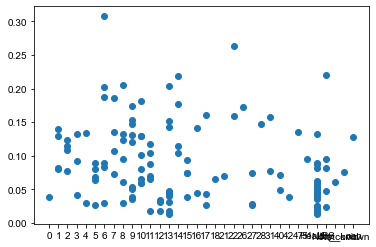

In [115]:
plt.scatter(res[0], res[3])

In [116]:
spearmanr(res[0], res[3])

SpearmanrResult(correlation=-0.12627988013288977, pvalue=0.15064774180585358)